# Decoding in sensor's space

## Power Spectral Density (PSD)

### Create matrice of labels

In [ ]:
# -----------------------
# STOP-IN:
# -----------------------

# Total number of trials
total_trials_si = 642

# Create a label array
labels_si = np.zeros(total_trials_si, dtype=int)

# Set labels for each condition
labels_si[:214] = 0  # The first 214 trials have label 0 (solo)
labels_si[214:214+214] = 1  # The next 214 trials have label 1 (easy)
labels_si[214+214:] = 2  # The last 214 trials have label 2 (hard)

# Check the label array
print(labels_si)
print("Total number of trials:", len(labels_si))
print("Number of trials with label 0 (solo):", np.sum(labels_si == 0))
print("Number of trials with label 1 (easy):", np.sum(labels_si == 1))
print("Number of trials with label 2 (hard):", np.sum(labels_si == 2))

# -----------------------
# PUNCH-THROUGH:
# -----------------------

# Total number of trials
total_trials_pt = 642

# Create a label array
labels_pt = np.zeros(total_trials_pt, dtype=int)

# Set labels for each condition
labels_pt[:214] = 0  # The first 214 trials have label 0 (solo)
labels_pt[214:214+214] = 1  # The next 214 trials have label 1 (easy)
labels_pt[214+214:] = 2  # The last 214 trials have label 2 (hard)

# Check the label array
print(labels_pt)
print("Total number of trials:", len(labels_pt))
print("Number of trials with label 0 (solo):", np.sum(labels_pt == 0))
print("Number of trials with label 1 (easy):", np.sum(labels_pt == 1))
print("Number of trials with label 2 (hard):", np.sum(labels_pt == 2))


### MLR + RFE

In [ ]:
def eval_classif_1(X, y):

    # Define parameters to test for grid search
    param_grid = {
        'C': [0.01, 0.1, 1.0, 10.0, 100.0],
        'penalty': ['l2'],
        'solver': ['lbfgs'],
        'max_iter': [5000] # 100, 500, 1000, 5000, 10000, 15000
    }

    # Initialize the logistic regression model
    clf = LogisticRegression(n_jobs=-1)

    # Perform grid search to find the best parameters
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Initialize cross-validation
    cv_seed = int(time.time())
    n_splits = 100
    cvs = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=cv_seed)
    acc = pd.DataFrame()
    cm = np.zeros([n_splits, 3, 3])

    # List to store feature rankings for each split
    rankings = []

    i_split = 0
    for train_ind, test_ind in tqdm(cvs.split(X, y)):
        # Train and test the classifier with the best parameters
        grid_search.fit(X[train_ind, :], y[train_ind])
        best_clf = grid_search.best_estimator_
        best_clf.fit(X[train_ind, :], y[train_ind])

        # Score on the training set
        d = {'type': ['train'], 'score': [best_clf.score(X[train_ind, :], y[train_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)

        # Score on the test set
        d = {'type': ['test'], 'score': [best_clf.score(X[test_ind, :], y[test_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)

        # Confusion matrix
        y_pred = best_clf.predict(X[test_ind, :])
        cm[i_split, :, :] = confusion_matrix(y[test_ind], y_pred, normalize='true')

        # best feature identification (post-hoc)
        rfe = RFE(estimator=best_clf, n_features_to_select=5, step=5) # step of 5 features sufficient for 128 channels
        rfe.fit(X[train_ind, :], y[train_ind])
        ranking = rfe.ranking_
        rankings.append(ranking)

        # Shuffle training indices
        train_ind_rand = np.random.permutation(train_ind)
        best_clf.fit(X[train_ind, :], y[train_ind_rand])

        # Score on the test set after shuffling
        d = {'type': ['shuf'], 'score': [best_clf.score(X[test_ind, :], y[test_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)

        i_split += 1



    # Convert rankings to DataFrame for further analysis
    rankings = np.array(rankings)

    # Calculate stability of rankings using Pearson correlation coefficient
    stability = np.zeros((n_splits, n_splits))
    for i in range(n_splits):
        for j in range(i + 1, n_splits):
            corr, _ = pearsonr(rankings[i], rankings[j])
            stability[i, j] = corr
            stability[j, i] = corr

    # Calculate mean ranking if rankings are stable (Pearson correlation coefficients above 0.6)
    mean_ranking = None
    if np.mean(stability) > 0.6:
        mean_ranking = np.mean(rankings, axis=0)
   

    return acc, cm, rankings, stability, mean_ranking


#### STOP-IN

##### Alpha

In [ ]:
# alpha
X_vect_alpha_si = psd_alpha_si.get_data()[:,:,0] # Reshape features to be 2D
y_labs_alpha_si = labels_si

print("Alpha : ")
print("Features : ",X_vect_alpha_si.shape)
print("Labels : ",y_labs_alpha_si.shape)

# -----------------------
# Matrix for all frequences :
# -----------------------

n_sample = y_labs_alpha_si.size
print('classes to predict:', np.unique(y_labs_alpha_si))

plt.figure()
plt.imshow(y_labs_alpha_si.reshape([n_sample,1]), aspect=0.03, interpolation='nearest', cmap='Set1')
plt.ylabel('sample index')
plt.xticks([])

plt.show()

# -----------------------
# Run function's classification   :
# -----------------------

#alpha

acc_alpha_1_si, cm_alpha_1_si, rankings_alpha_1_si, stability_alpha_1_si, mean_ranking_alpha_1_si = eval_classif_1(X_vect_alpha_si, y_labs_alpha_si) #MLR

# -----------------------
# Alpha plot MLR :
# -----------------------

# Alpha_MLR_Violonplot
sb.violinplot(data=acc_alpha_1_si, x='type', y='score', hue='type', density_norm='width', palette=['brown','blue','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('Alpha_MLR_Violonplot_si')
plt.show()

# Alpha MLR Matrix
plt.figure()
plt.imshow(cm_alpha_1_si.mean(0), cmap='Blues',vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('Alpha_MLR_Matrix_si')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()



# Plot results RFE
print("Feature rankings for each split:", rankings_alpha_1_si)
print("Rank stability matrix:", stability_alpha_1_si)
print("Mean feature ranking:", mean_ranking_alpha_1_si)

if mean_ranking_alpha_1_si is not None:
    best_features_indices = np.argsort(mean_ranking_alpha_1_si)
    print("Indices of the best features:", best_features_indices)

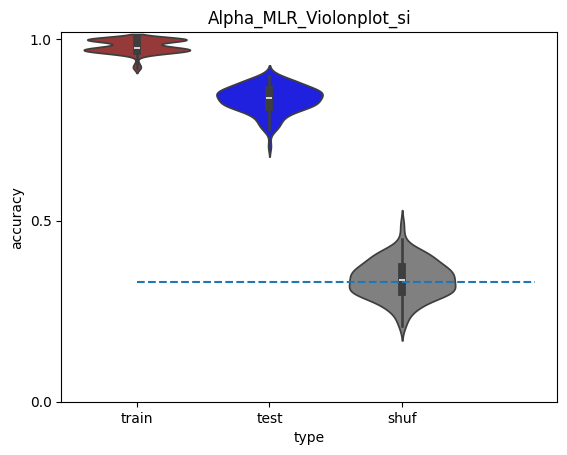 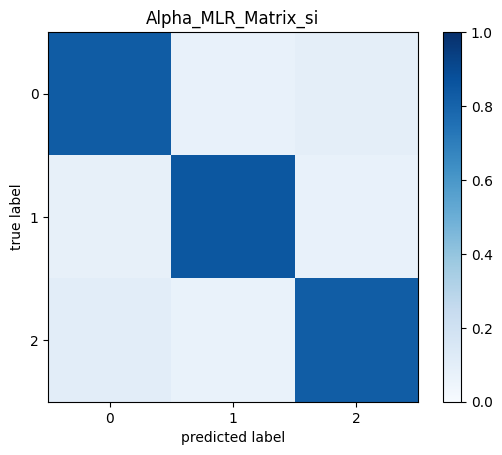 

##### Beta

In [ ]:
# beta
X_vect_beta_si = psd_beta_si.get_data()[:,:,0] # Reshape features to be 2D
y_labs_beta_si = labels_si

print("Beta : ")
print("Features : ",X_vect_beta_si.shape)
print("Labels : ",y_labs_beta_si.shape)

# -----------------------
# Matrix for all frequences :
# -----------------------

n_sample = y_labs_beta_si.size
print('classes to predict:', np.unique(y_labs_beta_si))

plt.figure()
plt.imshow(y_labs_beta_si.reshape([n_sample,1]), aspect=0.03, interpolation='nearest', cmap='Set1')
plt.ylabel('sample index')
plt.xticks([])

plt.show()


# -----------------------
# Run function's classification  :
# -----------------------

#beta
n_features_to_select = 10
acc_beta_1_si, cm_beta_1_si, rankings_beta_1_si, stability_beta_1_si, mean_ranking_beta_1_si = eval_classif_1(X_vect_beta_si, y_labs_beta_si) #MLR

# -----------------------
# Alpha plot MLR :
# -----------------------

# Alpha_MLR_Violonplot
sb.violinplot(data=acc_beta_1_si, x='type', y='score', hue='type', density_norm='width', palette=['brown','green','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('Beta_MLR_Violonplot_si')
plt.show()

# Alpha MLR Matrix
plt.figure()
plt.imshow(cm_beta_1_si.mean(0), cmap='Greens',vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('Beta_MLR_Matrix_si')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()

# Plot results RFE
print("Feature rankings for each split:", rankings_beta_1_si)
print("Rank stability matrix:", stability_beta_1_si)
print("Mean feature ranking:", mean_ranking_beta_1_si)

if mean_ranking_beta_1_si is not None:
    best_features_indices = np.argsort(mean_ranking_beta_1_si)[:n_features_to_select]
    print("Indices of the best features:", best_features_indices)

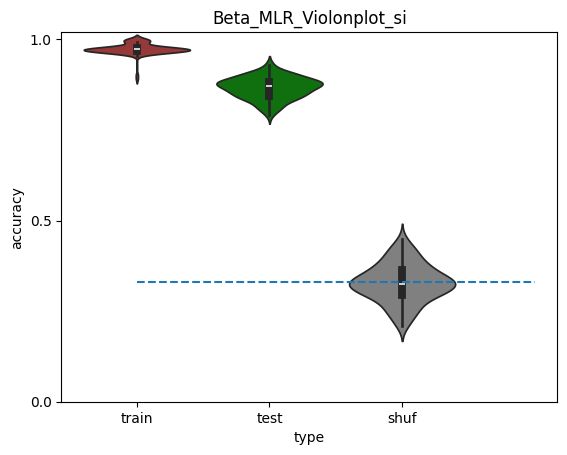 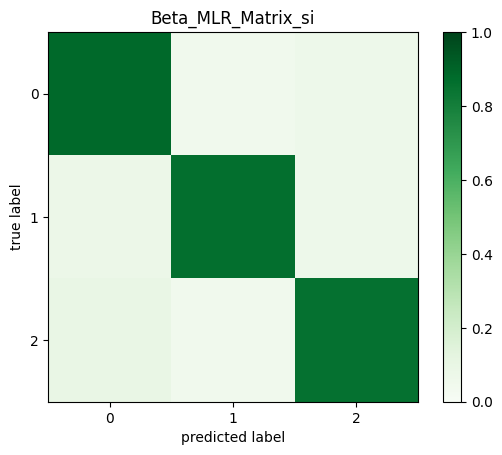 

##### Gamma

In [ ]:
# gamma
X_vect_gamma_si = psd_gamma_si.get_data()[:,:,0] # Reshape features to be 2D
y_labs_gamma_si = labels_si

print("Gamma : ")
print("Features : ",X_vect_gamma_si.shape)
print("Labels : ",y_labs_gamma_si.shape)

# -----------------------
# Matrix for all frequences :
# -----------------------

n_sample = y_labs_gamma_si.size
print('classes to predict:', np.unique(y_labs_gamma_si))

plt.figure()
plt.imshow(y_labs_gamma_si.reshape([n_sample,1]), aspect=0.03, interpolation='nearest', cmap='Set1')
plt.ylabel('sample index')
plt.xticks([])

plt.show()


# -----------------------
# Run function's classification   :
# -----------------------

#gamma
n_features_to_select = 10
acc_gamma_1_si, cm_gamma_1_si, rankings_gamma_1_si, stability_gamma_1_si, mean_ranking_gamma_1_si = eval_classif_1(X_vect_gamma_si, y_labs_gamma_si) #MLR

# -----------------------
# gamma plot MLR  :
# -----------------------

# gamma_MLR_Violonplot
sb.violinplot(data=acc_gamma_1_si, x='type', y='score', hue='type', density_norm='width', palette=['brown','red','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('gamma_MLR_Violonplot_si')
plt.show()

# gamma MLR Matrix
plt.figure()
plt.imshow(cm_gamma_1_si.mean(0), cmap='Reds',vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('gamma_MLR_Matrix_si')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()

# Plot results RFE
print("Feature rankings for each split:", rankings_gamma_1_si)
print("Rank stability matrix:", stability_gamma_1_si)
print("Mean feature ranking:", mean_ranking_gamma_1_si)

if mean_ranking_gamma_1_si is not None:
    best_features_indices = np.argsort(mean_ranking_gamma_1_si)[:n_features_to_select]
    print("Indices of the best features:", best_features_indices)

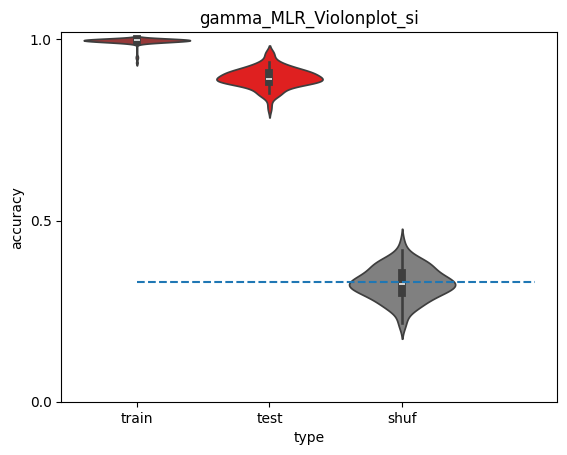 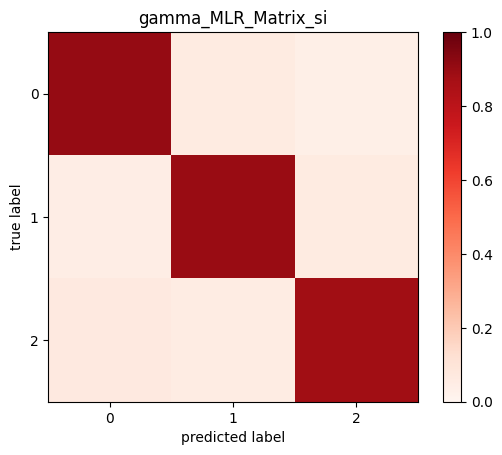 

##### RFE on 10 best electrodes on gamma

In [ ]:
sfreq = 500.0 # np.diff(X).mean() if not sure about the freq
info_gamma_si = mne.create_info( ch_names=montage.ch_names, sfreq=sfreq, ch_types="eeg", verbose = None)
info_gamma_si["bads"] = ["EEG85","EEG79","EEG97","EEG12","EEG7","EEG63","EEG95","EEG92","EEG1","EEG13"]
info_gamma_si.set_montage(montage)
# Créer une figure pour le tracé des capteurs
fig = mne.viz.plot_sensors(info_gamma_si, show_names=False)

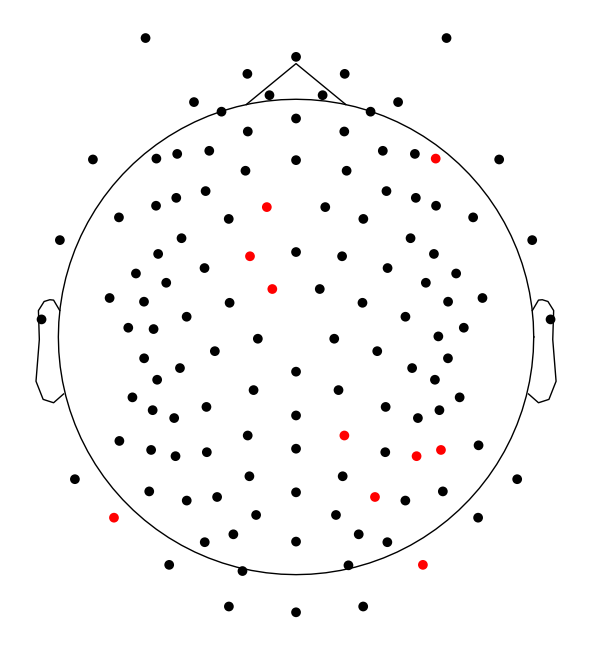

#### PUNCH-TROUG

##### Alpha

In [ ]:
# alpha
X_vect_alpha_pt = psd_alpha_pt.get_data()[:,:,0] # Reshape features to be 2D
y_labs_alpha_pt = labels_pt

print("Alpha : ")
print("Features : ",X_vect_alpha_pt.shape)
print("Labels : ",y_labs_alpha_pt.shape)

# -----------------------
# Matrix for all frequences :
# -----------------------

n_sample = y_labs_alpha_pt.size
print('classes to predict:', np.unique(y_labs_alpha_pt))

plt.figure()
plt.imshow(y_labs_alpha_pt.reshape([n_sample,1]), aspect=0.03, interpolation='nearest', cmap='Set1')
plt.ylabel('sample index')
plt.xticks([])

plt.show()

# -----------------------
# Run function's classification :
# -----------------------

#alpha
n_features_to_select = 10
acc_alpha_1_pt, cm_alpha_1_pt, rankings_alpha_1_pt, stability_alpha_1_pt, mean_ranking_alpha_1_pt = eval_classif_1(X_vect_alpha_pt, y_labs_alpha_pt) #MLR


# -----------------------
# Alpha plot MLR  :
# -----------------------

# Alpha_MLR_Violonplot
sb.violinplot(data=acc_alpha_1_pt, x='type', y='score', hue='type', density_norm='width', palette=['brown','blue','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('Alpha_MLR_Violonplot_pt')
plt.show()

# Alpha MLR Matrix
plt.figure()
plt.imshow(cm_alpha_1_pt.mean(0), cmap='Blues',vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('Alpha_MLR_Matrix_pt')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()

# Plot results RFE
print("Feature rankings for each split:", rankings_alpha_1_pt)
print("Rank stability matrix:", stability_alpha_1_pt)
print("Mean feature ranking:", mean_ranking_alpha_1_pt)

if mean_ranking_alpha_1_pt is not None:
    best_features_indices = np.argsort(mean_ranking_alpha_1_pt)[:n_features_to_select]
    print("Indices of the best features:", best_features_indices)

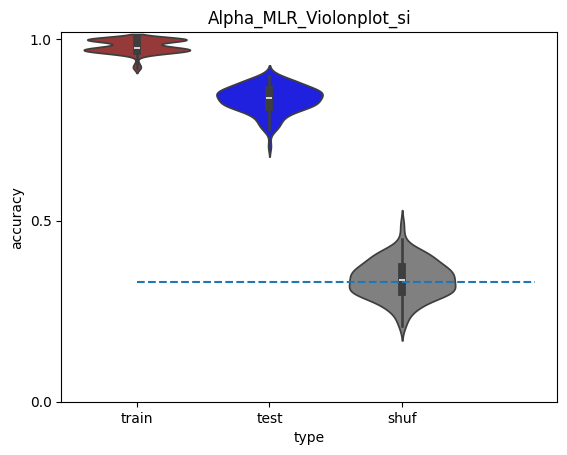 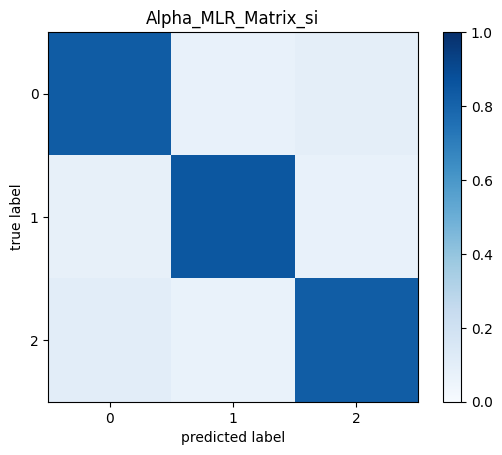

##### Beta

In [ ]:
# beta
X_vect_beta_pt = psd_beta_pt.get_data()[:,:,0] # Reshape features to be 2D
y_labs_beta_pt = labels_pt

print("Beta : ")
print("Features : ",X_vect_beta_pt.shape)
print("Labels : ",y_labs_beta_pt.shape)

# -----------------------
# Matrix for all frequences :
# -----------------------

n_sample = y_labs_beta_pt.size
print('classes to predict:', np.unique(y_labs_beta_pt))

plt.figure()
plt.imshow(y_labs_beta_pt.reshape([n_sample,1]), aspect=0.03, interpolation='nearest', cmap='Set1')
plt.ylabel('sample index')
plt.xticks([])

plt.show()


# -----------------------
# Run function's classification  :
# -----------------------

#beta
n_features_to_select = 10
acc_beta_1_pt, cm_beta_1_pt, rankings_beta_1_pt, stability_beta_1_pt, mean_ranking_beta_1_pt = eval_classif_1(X_vect_beta_pt, y_labs_beta_pt) #MLR

# -----------------------
# Alpha plot MLR   :
# -----------------------

# Alpha_MLR_Violonplot
sb.violinplot(data=acc_beta_1_pt, x='type', y='score', hue='type', density_norm='width', palette=['brown','green','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('Beta_MLR_Violonplot_pt')
plt.show()

# Alpha MLR Matrix
plt.figure()
plt.imshow(cm_beta_1_pt.mean(0), cmap='Greens',vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('Beta_MLR_Matrix_pt')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()

# Plot results RFE
print("Feature rankings for each split:", rankings_beta_1_pt)
print("Rank stability matrix:", stability_beta_1_pt)
print("Mean feature ranking:", mean_ranking_beta_1_pt)

if mean_ranking_beta_1_pt is not None:
    best_features_indices = np.argsort(mean_ranking_beta_1_pt)[:n_features_to_select]
    print("Indices of the best features:", best_features_indices)

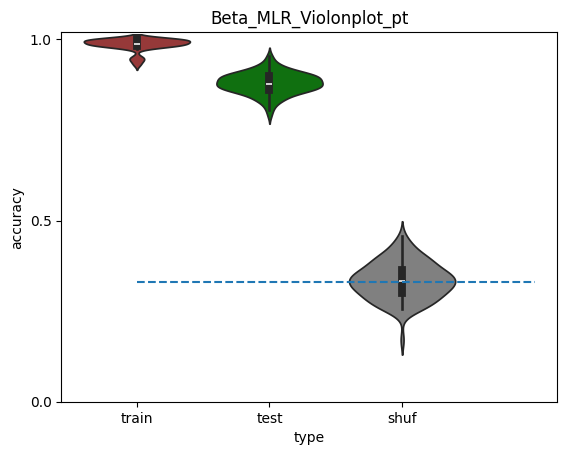 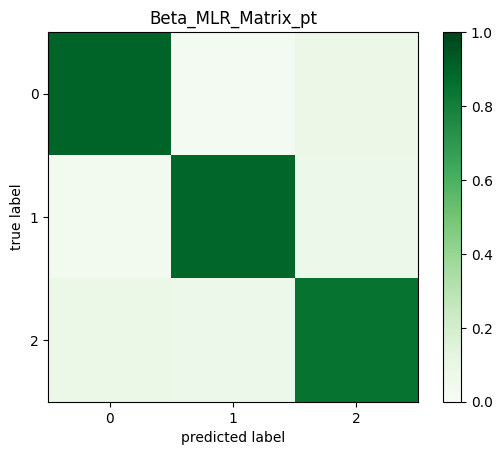

##### Gamma

In [ ]:
# gamma
X_vect_gamma_pt = psd_gamma_pt.get_data()[:,:,0] # Reshape features to be 2D
y_labs_gamma_pt = labels_pt

print("Gamma : ")
print("Features : ",X_vect_gamma_pt.shape)
print("Labels : ",y_labs_gamma_pt.shape)

# -----------------------
# Matrix for all frequences :
# -----------------------

n_sample = y_labs_gamma_pt.size
print('classes to predict:', np.unique(y_labs_gamma_pt))

plt.figure()
plt.imshow(y_labs_gamma_pt.reshape([n_sample,1]), aspect=0.03, interpolation='nearest', cmap='Set1')
plt.ylabel('sample index')
plt.xticks([])

plt.show()


# -----------------------
# Run function's classification on each band and ts  :
# -----------------------

#gamma
n_features_to_select = 10
acc_gamma_1_pt, cm_gamma_1_pt, rankings_gamma_1_pt, stability_gamma_1_pt, mean_ranking_gamma_1_pt = eval_classif_1(X_vect_gamma_pt, y_labs_gamma_pt) #MLR

# -----------------------
# gamma plot MLR  :
# -----------------------

# gamma_MLR_Violonplot
sb.violinplot(data=acc_gamma_1_pt, x='type', y='score', hue='type', density_norm='width', palette=['brown','red','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('gamma_MLR_Violonplot_pt')
plt.show()

# gamma MLR Matrix
plt.figure()
plt.imshow(cm_gamma_1_pt.mean(0), cmap='Reds',vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('gamma_MLR_Matrix_pt')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()

# Plot results RFE
print("Feature rankings for each split:", rankings_gamma_1_pt)
print("Rank stability matrix:", stability_gamma_1_pt)
print("Mean feature ranking:", mean_ranking_gamma_1_pt)

if mean_ranking_gamma_1_pt is not None:
    best_features_indices = np.argsort(mean_ranking_gamma_1_pt)[:n_features_to_select]
    print("Indices of the best features:", best_features_indices)

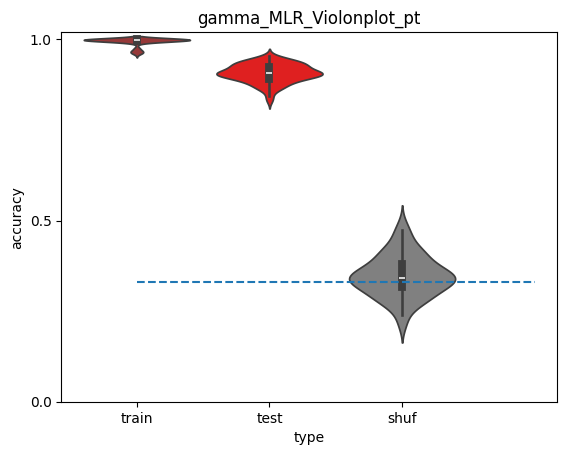 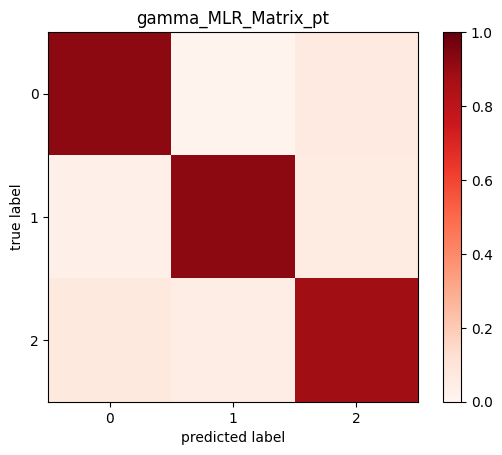

##### RFE on the 10 best electrodes on gamma

In [ ]:
sfreq = 500.0 # np.diff(X).mean() if not sure about the freq
info_gamma_pt = mne.create_info( ch_names=montage.ch_names, sfreq=sfreq, ch_types="eeg", verbose = None)
info_gamma_pt["bads"] = ["EEG60","EEG84","EEG6","EEG53","EEG12","EEG95","EEG33","EEG55","EEG91","EEG77"]
info_gamma_pt.set_montage(montage)
# Créer une figure pour le tracé des capteurs
fig = mne.viz.plot_sensors(info_gamma_pt, show_names=False)

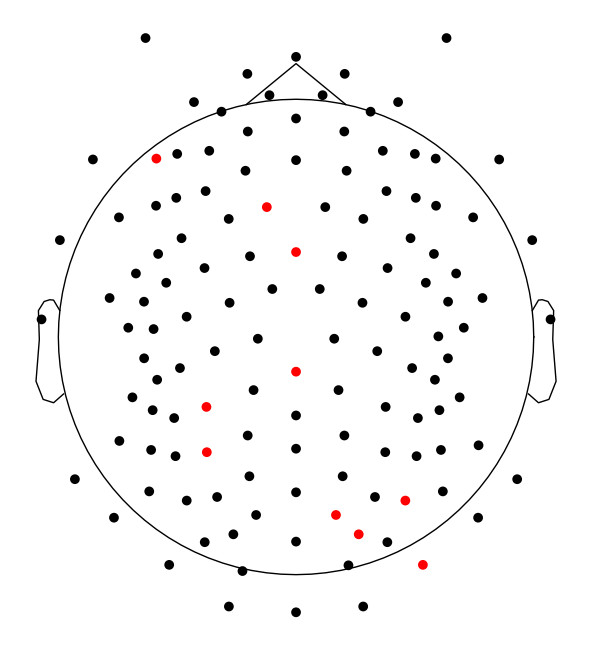

### kNN

In [ ]:
# -----------------------
# Function for the 1NN:
# -----------------------

def eval_classif_2(X, y):

    param_grid = {
        'n_neighbors': [1],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski'],
        'algorithm': ['auto',  'brute'],
    }

    # Initialize the k-NN model
    clf_1NN = KNeighborsClassifier()

    # Perform grid search to find the best parameters
    grid_search = GridSearchCV(clf_1NN, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Initialize cross-validation
    cv_seed = int(time.time())
    n_rep = 100
    cvs = StratifiedShuffleSplit(n_splits=n_rep, test_size=0.2, random_state=cv_seed)
    acc = pd.DataFrame()
    cm = np.zeros([n_rep, 3, 3])

    i_rep = 0
    for train_ind, test_ind in tqdm(cvs.split(X, y)):

        # Train and test the classifier with the best parameters
        grid_search.fit(X[train_ind, :], y[train_ind])
        best_clf = grid_search.best_estimator_
        best_clf.fit(X[train_ind, :], y[train_ind])

        # Accuracy on the training set
        d = {'type': ['train'],
             'score': [best_clf.score(X[train_ind, :], y[train_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)

        # Accuracy on the test set
        d = {'type': ['test'],
             'score': [best_clf.score(X[test_ind, :], y[test_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)

        # Confusion matrix
        y_pred = best_clf.predict(X[test_ind, :])
        cm[i_rep-1, :, :] = confusion_matrix(y[test_ind], y_pred, normalize='true')

        # Shuffling
        train_ind_rand = np.random.permutation(train_ind)
        best_clf.fit(X[train_ind, :], y[train_ind_rand])

        # Accuracy on the test set after shuffling
        d = {'type': ['shuf'],
             'score': [best_clf.score(X[test_ind, :], y[test_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)

        i_rep += 1

    return acc, cm


#### STOp-IN

##### Alpha

In [ ]:
# alpha
X_vect_alpha_si = psd_alpha_si.get_data()[:,:,0] # Reshape features to be 2D
y_labs_alpha_si = labels_si

print("Alpha : ")
print("Features : ",X_vect_alpha_si.shape)
print("Labels : ",y_labs_alpha_si.shape)

# -----------------------
# Matrix for all frequences :
# -----------------------

n_sample = y_labs_alpha_si.size
print('classes to predict:', np.unique(y_labs_alpha_si))

plt.figure()
plt.imshow(y_labs_alpha_si.reshape([n_sample,1]), aspect=0.03, interpolation='nearest', cmap='Set1')
plt.ylabel('sample index')
plt.xticks([])

plt.show()

# -----------------------
# Run function's classification  :
# -----------------------

#alpha
acc_alpha_2_si, cm_alpha_2_si = eval_classif_2(X_vect_alpha_si, y_labs_alpha_si) #MLR

# -----------------------
# Alpha plot kNN  :
# -----------------------

# Alpha_knn_Violonplot
sb.violinplot(data=acc_alpha_2_si, x='type', y='score', hue='type', density_norm='width', palette=['brown','blue','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('Alpha_kNN_Violonplot_si')
plt.show()

# Alpha kNN Matrix
plt.figure()
plt.imshow(cm_alpha_2_si.mean(0), cmap='Blues',vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('Alpha_kNN_Matrix_si')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()


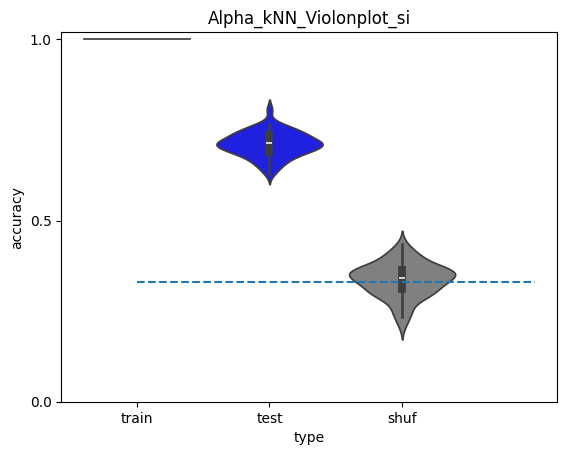 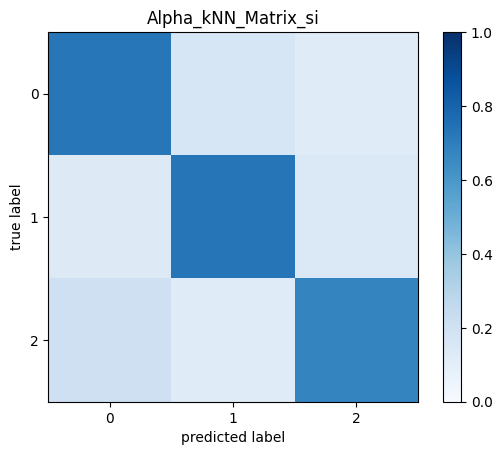

##### Beta

In [ ]:
# beta
X_vect_beta_si = psd_beta_si.get_data()[:,:,0] # Reshape features to be 2D
y_labs_beta_si = labels_si

print("Beta : ")
print("Features : ",X_vect_beta_si.shape)
print("Labels : ",y_labs_beta_si.shape)

# -----------------------
# Matrix for all frequences :
# -----------------------

n_sample = y_labs_beta_si.size
print('classes to predict:', np.unique(y_labs_beta_si))

plt.figure()
plt.imshow(y_labs_beta_si.reshape([n_sample,1]), aspect=0.03, interpolation='nearest', cmap='Set1')
plt.ylabel('sample index')
plt.xticks([])

plt.show()


# -----------------------
# Run function's classification :
# -----------------------

#beta
acc_beta_2_si, cm_beta_2_si = eval_classif_2(X_vect_beta_si, y_labs_beta_si) #MLR

# -----------------------
# Alpha plot  kNN  :
# -----------------------

# Alpha_kNN_Violonplot
sb.violinplot(data=acc_beta_2_si, x='type', y='score', hue='type', density_norm='width', palette=['brown','green','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('Beta_kNN_Violonplot_si')
plt.show()

# Alpha kNN Matrix
plt.figure()
plt.imshow(cm_beta_2_si.mean(0), cmap='Greens',vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('Beta_kNN_Matrix_si')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()

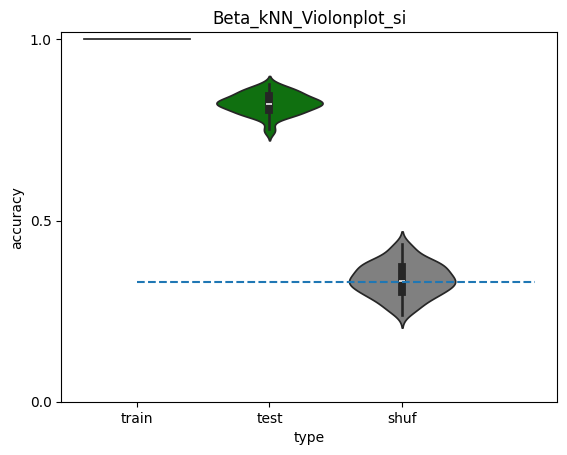 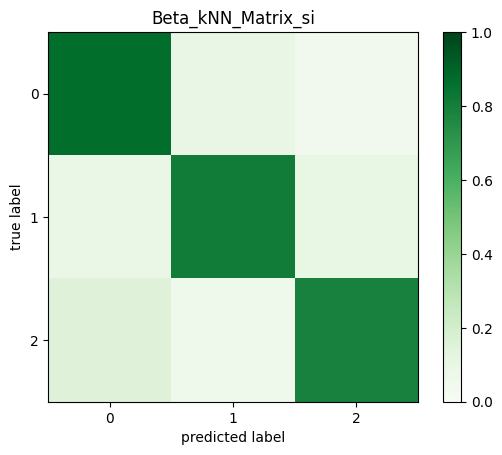

##### Gamma

In [ ]:
# gamma
X_vect_gamma_si = psd_gamma_si.get_data()[:,:,0] # Reshape features to be 2D
y_labs_gamma_si = labels_si

print("Gamma : ")
print("Features : ",X_vect_gamma_si.shape)
print("Labels : ",y_labs_gamma_si.shape)

# -----------------------
# Matrix for all frequences :
# -----------------------

n_sample = y_labs_gamma_si.size
print('classes to predict:', np.unique(y_labs_gamma_si))

plt.figure()
plt.imshow(y_labs_gamma_si.reshape([n_sample,1]), aspect=0.03, interpolation='nearest', cmap='Set1')
plt.ylabel('sample index')
plt.xticks([])

plt.show()


# -----------------------
# Run function's classification:
# -----------------------

#gamma
acc_gamma_2_si, cm_gamma_2_si = eval_classif_2(X_vect_gamma_si, y_labs_gamma_si) #MLR

# -----------------------
# gamma plot kNN  :
# -----------------------

# gamma_kNN_Violonplot
sb.violinplot(data=acc_gamma_2_si, x='type', y='score', hue='type', density_norm='width', palette=['brown','red','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('gamma_kNN_Violonplot_si')
plt.show()

# gamma kNN Matrix
plt.figure()
plt.imshow(cm_gamma_2_si.mean(0), cmap='Reds',vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('gamma_kNN_Matrix_si')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()

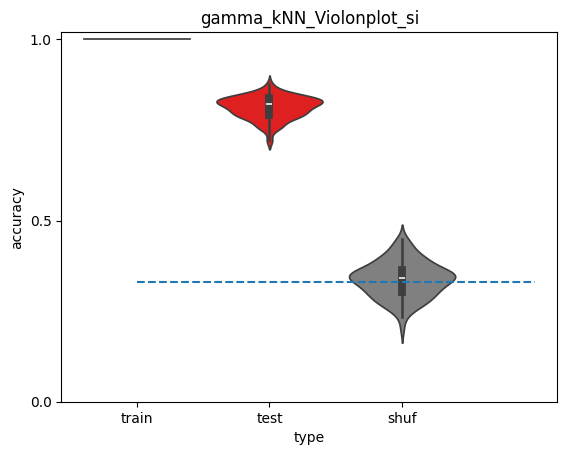   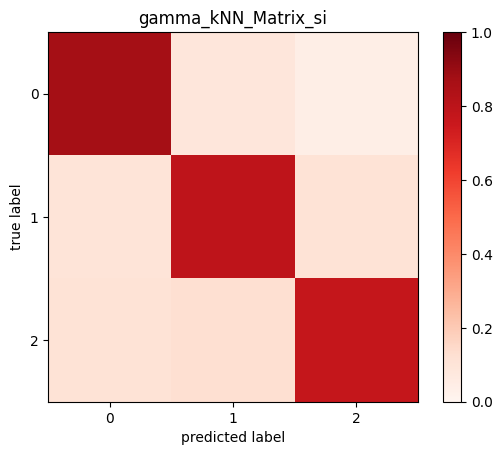

#### PUNCH-TROUGH

##### Alpha

In [ ]:
# alpha
X_vect_alpha_pt = psd_alpha_pt.get_data()[:,:,0] # Reshape features to be 2D
y_labs_alpha_pt = labels_pt

print("Alpha : ")
print("Features : ",X_vect_alpha_pt.shape)
print("Labels : ",y_labs_alpha_pt.shape)

# -----------------------
# Matrix for all frequences :
# -----------------------

n_sample = y_labs_alpha_pt.size
print('classes to predict:', np.unique(y_labs_alpha_pt))

plt.figure()
plt.imshow(y_labs_alpha_pt.reshape([n_sample,1]), aspect=0.03, interpolation='nearest', cmap='Set1')
plt.ylabel('sample index')
plt.xticks([])

plt.show()

# -----------------------
# Run function's classification :
# -----------------------

#alpha
acc_alpha_2_pt, cm_alpha_2_pt = eval_classif_2(X_vect_alpha_pt, y_labs_alpha_pt) #MLR


# -----------------------
# Alpha plot kNN  :
# -----------------------

# Alpha_kNN_Violonplot
sb.violinplot(data=acc_alpha_2_pt, x='type', y='score', hue='type', density_norm='width', palette=['brown','blue','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('Alpha_kNN_Violonplot_pt')
plt.show()

# Alpha KNN Matrix
plt.figure()
plt.imshow(cm_alpha_2_pt.mean(0), cmap='Blues',vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('Alpha_kNN_Matrix_pt')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()

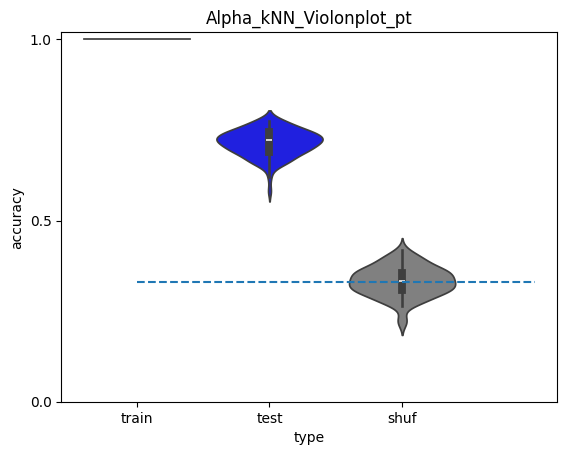 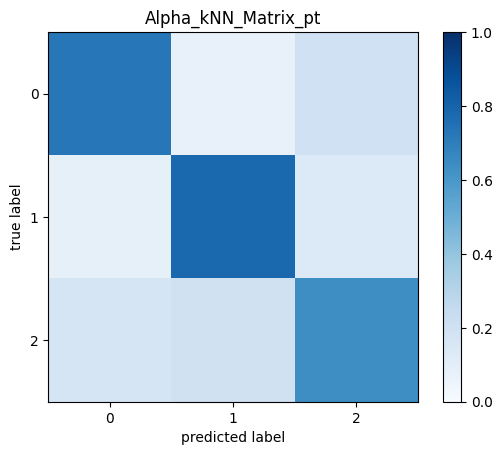

##### Beta

In [ ]:
# beta
X_vect_beta_pt = psd_beta_pt.get_data()[:,:,0] # Reshape features to be 2D
y_labs_beta_pt = labels_pt

print("Beta : ")
print("Features : ",X_vect_beta_pt.shape)
print("Labels : ",y_labs_beta_pt.shape)

# -----------------------
# Matrix for all frequences :
# -----------------------

n_sample = y_labs_beta_pt.size
print('classes to predict:', np.unique(y_labs_beta_pt))

plt.figure()
plt.imshow(y_labs_beta_pt.reshape([n_sample,1]), aspect=0.03, interpolation='nearest', cmap='Set1')
plt.ylabel('sample index')
plt.xticks([])

plt.show()


# -----------------------
# Run function's classification :
# -----------------------

#beta
acc_beta_2_pt, cm_beta_2_pt = eval_classif_2(X_vect_beta_pt, y_labs_beta_pt) #MLR

# -----------------------
# Beta plot kNN  :
# -----------------------

# Beta_kNN_Violonplot
sb.violinplot(data=acc_beta_2_pt, x='type', y='score', hue='type', density_norm='width', palette=['brown','green','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('Beta_kNN_Violonplot_pt')
plt.show()

# Beta kNN Matrix
plt.figure()
plt.imshow(cm_beta_2_pt.mean(0), cmap='Greens',vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('Beta_kNN_Matrix_pt')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()

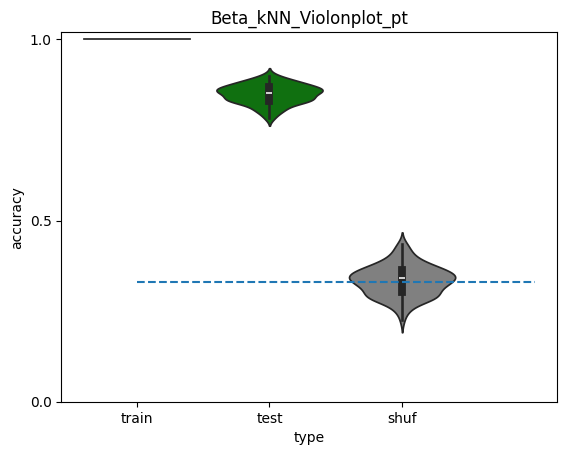 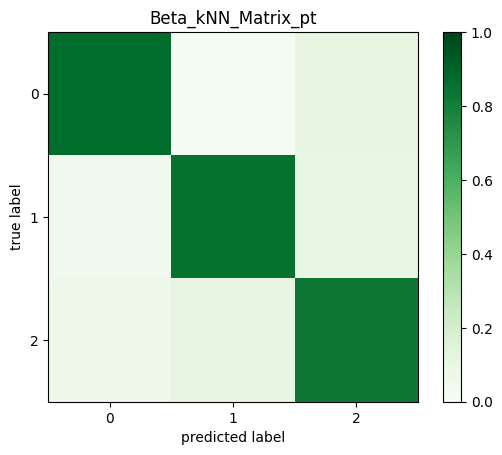

##### Gamma

In [ ]:
# gamma
X_vect_gamma_pt = psd_gamma_pt.get_data()[:,:,0] # Reshape features to be 2D
y_labs_gamma_pt = labels_pt

print("Gamma : ")
print("Features : ",X_vect_gamma_pt.shape)
print("Labels : ",y_labs_gamma_pt.shape)

# -----------------------
# Matrix for all frequences :
# -----------------------

n_sample = y_labs_gamma_pt.size
print('classes to predict:', np.unique(y_labs_gamma_pt))

plt.figure()
plt.imshow(y_labs_gamma_pt.reshape([n_sample,1]), aspect=0.03, interpolation='nearest', cmap='Set1')
plt.ylabel('sample index')
plt.xticks([])

plt.show()


# -----------------------
# Run function's classification on each band and ts  :
# -----------------------

#gamma
acc_gamma_2_pt, cm_gamma_2_pt = eval_classif_2(X_vect_gamma_pt, y_labs_gamma_pt) #MLR

# -----------------------
# gamma plot kNN  :
# -----------------------

# gamma_kNN_Violonplot
sb.violinplot(data=acc_gamma_2_pt, x='type', y='score', hue='type', density_norm='width', palette=['brown','red','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('gamma_kNN_Violonplot_pt')
plt.show()

# gamma kNN Matrix
plt.figure()
plt.imshow(cm_gamma_2_pt.mean(0), cmap='Reds',vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('gamma_kNN_Matrix_pt')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()

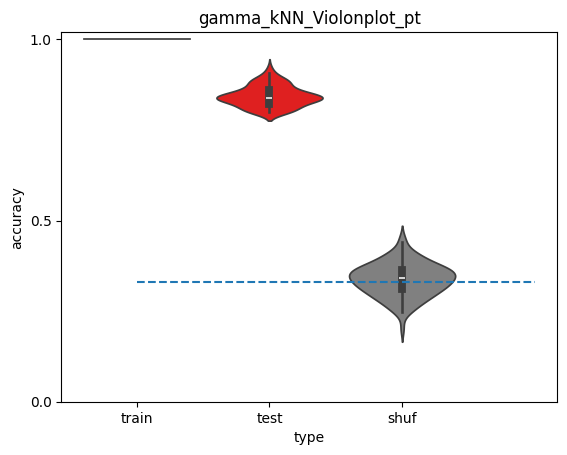 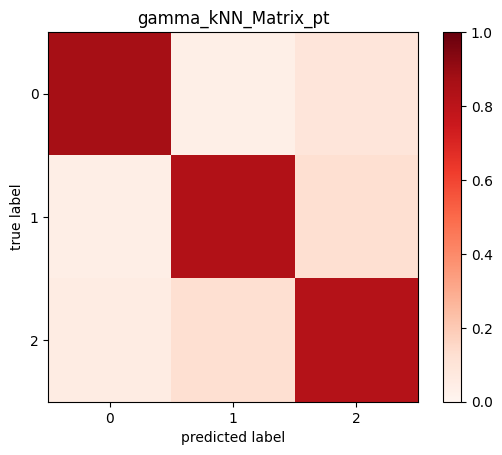

### Random Forest

In [ ]:
def eval_classif_3(X, y):
     
    param_grid = {
        'n_estimators': [50, 100, 200],
        'criterion': ['gini', 'entropy'],
        
    }

    # Initialize the Random Forest model
    clf_RF = RandomForestClassifier(n_jobs=-1)

    # Perform grid search to find the best parameters
    grid_search = GridSearchCV(clf_RF, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Initialize cross-validation
    cv_seed = int(time.time())
    n_rep = 100
    cvs = StratifiedShuffleSplit(n_splits=n_rep, test_size=0.2, random_state=cv_seed)
    acc = pd.DataFrame()
    cm = np.zeros([n_rep, 3, 3])

    i_rep = 0
    for train_ind, test_ind in tqdm(cvs.split(X, y)):

        # Train and test the classifier with the best parameters
        grid_search.fit(X[train_ind, :], y[train_ind])
        best_clf = grid_search.best_estimator_
        best_clf.fit(X[train_ind, :], y[train_ind])

        # Accuracy on the training set
        d = {'type': ['train'],
             'score': [best_clf.score(X[train_ind, :], y[train_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)

        # Accuracy on the test set
        d = {'type': ['test'],
             'score': [best_clf.score(X[test_ind, :], y[test_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)

        # Confusion matrix
        y_pred = best_clf.predict(X[test_ind, :])
        cm[i_rep, :, :] = confusion_matrix(y[test_ind], y_pred, normalize='true')

        # Shuffling
        train_ind_rand = np.random.permutation(train_ind)
        best_clf.fit(X[train_ind, :], y[train_ind_rand])

        # Accuracy on the test set after shuffling
        d = {'type': ['shuf'],
             'score': [best_clf.score(X[test_ind, :], y[test_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)

        i_rep += 1

    return acc, cm



#### STOP-IN

##### Alpha

In [ ]:
# alpha
X_vect_alpha_si = psd_alpha_si.get_data()[:,:,0] # Reshape features to be 2D
y_labs_alpha_si = labels_si

print("Alpha : ")
print("Features : ",X_vect_alpha_si.shape)
print("Labels : ",y_labs_alpha_si.shape)

# -----------------------
# Matrix for all frequences :
# -----------------------

n_sample = y_labs_alpha_si.size
print('classes to predict:', np.unique(y_labs_alpha_si))

plt.figure()
plt.imshow(y_labs_alpha_si.reshape([n_sample,1]), aspect=0.03, interpolation='nearest', cmap='Set1')
plt.ylabel('sample index')
plt.xticks([])

plt.show()

# -----------------------
# Run function's classification   :
# -----------------------

#alpha
acc_alpha_3_si, cm_alpha_3_si = eval_classif_3(X_vect_alpha_si, y_labs_alpha_si) #MLR

# -----------------------
# Alpha plot RF  :
# -----------------------

# Alpha_rf_Violonplot
sb.violinplot(data=acc_alpha_3_si, x='type', y='score', hue='type', density_norm='width', palette=['brown','blue','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('Alpha_RF_Violonplot_si')
plt.show()

# Alpha RF Matrix
plt.figure()
plt.imshow(cm_alpha_3_si.mean(0), cmap='Blues',vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('Alpha_RF_Matrix_si')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()

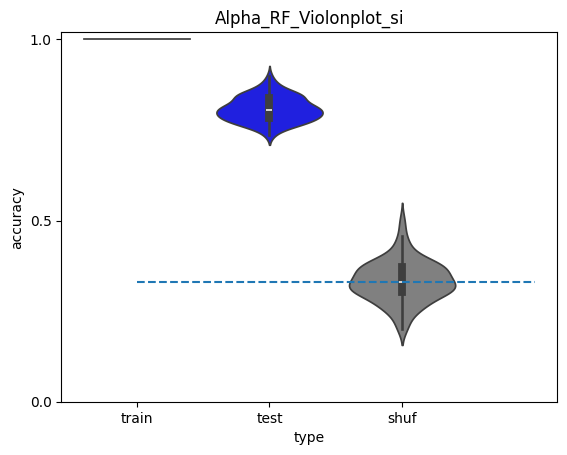 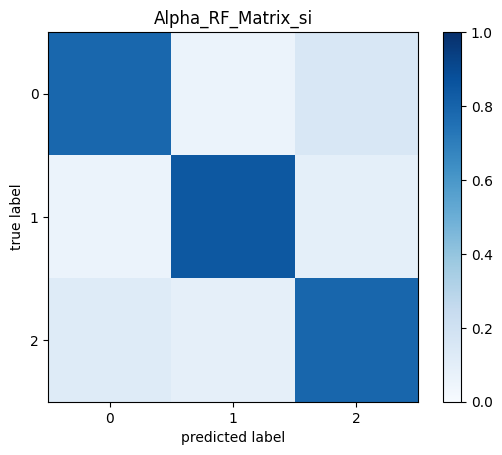

##### Beta

In [ ]:
# beta
X_vect_beta_si = psd_beta_si.get_data()[:,:,0] # Reshape features to be 2D
y_labs_beta_si = labels_si

print("Beta : ")
print("Features : ",X_vect_beta_si.shape)
print("Labels : ",y_labs_beta_si.shape)

# -----------------------
# Matrix for all frequences :
# -----------------------

n_sample = y_labs_beta_si.size
print('classes to predict:', np.unique(y_labs_beta_si))

plt.figure()
plt.imshow(y_labs_beta_si.reshape([n_sample,1]), aspect=0.03, interpolation='nearest', cmap='Set1')
plt.ylabel('sample index')
plt.xticks([])

plt.show()


# -----------------------
# Run function's classification   :
# -----------------------

#beta
acc_beta_3_si, cm_beta_3_si = eval_classif_3(X_vect_beta_si, y_labs_beta_si) #MLR

# -----------------------
#  Beta plot RF :
# -----------------------

# Beta_RF_Violonplot
sb.violinplot(data=acc_beta_3_si, x='type', y='score', hue='type', density_norm='width', palette=['brown','green','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('Beta_RF_Violonplot_si')
plt.show()
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('Beta_RF_Matrix_si')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()

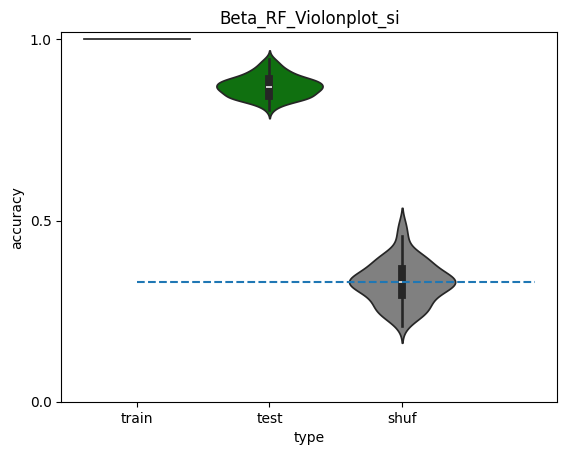 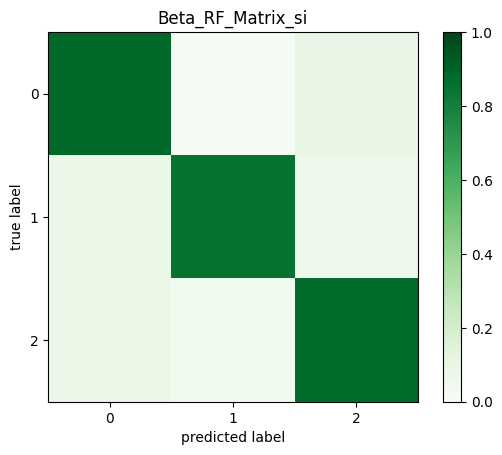

##### Gamma

In [ ]:
# gamma
X_vect_gamma_si = psd_gamma_si.get_data()[:,:,0] # Reshape features to be 2D
y_labs_gamma_si = labels_si

print("Gamma : ")
print("Features : ",X_vect_gamma_si.shape)
print("Labels : ",y_labs_gamma_si.shape)

# -----------------------
# Matrix for all frequences :
# -----------------------

n_sample = y_labs_gamma_si.size
print('classes to predict:', np.unique(y_labs_gamma_si))

plt.figure()
plt.imshow(y_labs_gamma_si.reshape([n_sample,1]), aspect=0.03, interpolation='nearest', cmap='Set1')
plt.ylabel('sample index')
plt.xticks([])

plt.show()


# -----------------------
# Run function's classification  :
# -----------------------

#gamma
acc_gamma_3_si, cm_gamma_3_si = eval_classif_3(X_vect_gamma_si, y_labs_gamma_si) #MLR

# -----------------------
# gamma plot RF :
# -----------------------

# gamma_RF_Violonplot
sb.violinplot(data=acc_gamma_3_si, x='type', y='score', hue='type', density_norm='width', palette=['brown','red','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('gamma_RF_Violonplot_si')
plt.show()

# gamma RF Matrix
plt.figure()
plt.imshow(cm_gamma_1_si.mean(0), cmap='Reds',vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('gamma_RF_Matrix_si')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()

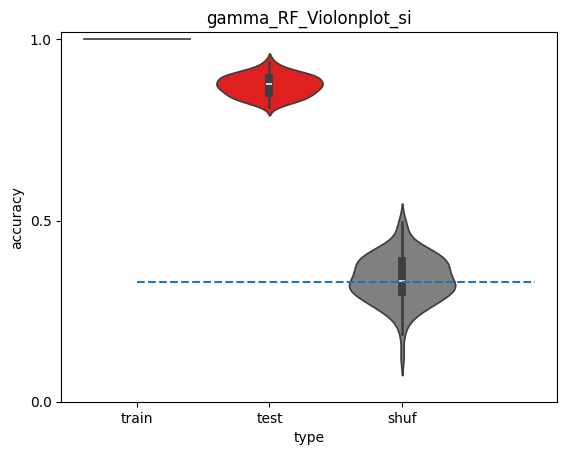 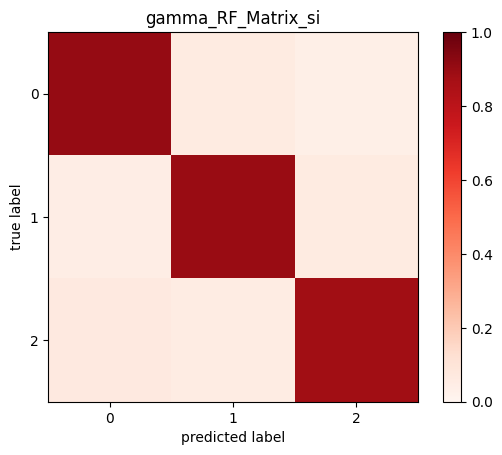

#### PUNCH-TROUGH

##### Alpha

In [ ]:
# alpha
X_vect_alpha_pt = psd_alpha_pt.get_data()[:,:,0] # Reshape features to be 2D
y_labs_alpha_pt = labels_pt

print("Alpha : ")
print("Features : ",X_vect_alpha_pt.shape)
print("Labels : ",y_labs_alpha_pt.shape)

# -----------------------
# Matrix for all frequences :
# -----------------------

n_sample = y_labs_alpha_pt.size
print('classes to predict:', np.unique(y_labs_alpha_pt))

plt.figure()
plt.imshow(y_labs_alpha_pt.reshape([n_sample,1]), aspect=0.03, interpolation='nearest', cmap='Set1')
plt.ylabel('sample index')
plt.xticks([])

plt.show()

# -----------------------
# Run function's classification  :
# -----------------------

#alpha
acc_alpha_3_pt, cm_alpha_3_pt = eval_classif_3(X_vect_alpha_pt, y_labs_alpha_pt) #MLR


# -----------------------
# Alpha plot RF  :
# -----------------------

# Alpha_RF_Violonplot
sb.violinplot(data=acc_alpha_3_pt, x='type', y='score', hue='type', density_norm='width', palette=['brown','blue','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('Alpha_RF_Violonplot_pt')
plt.show()

# Alpha rf Matrix
plt.figure()
plt.imshow(cm_alpha_3_pt.mean(0), cmap='Blues',vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('Alpha_RF_Matrix_pt')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()

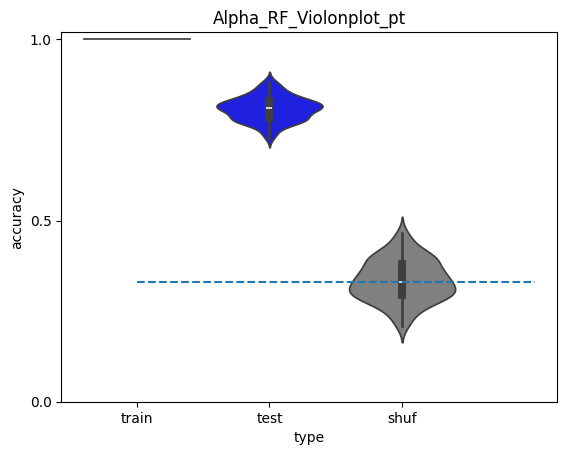 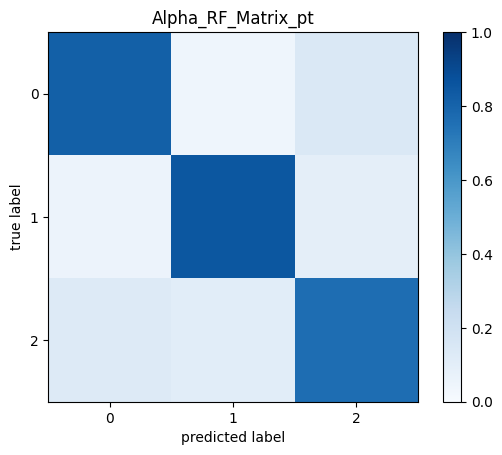

##### Beta

In [ ]:
# beta
X_vect_beta_pt = psd_beta_pt.get_data()[:,:,0] # Reshape features to be 2D
y_labs_beta_pt = labels_pt

print("Beta : ")
print("Features : ",X_vect_beta_pt.shape)
print("Labels : ",y_labs_beta_pt.shape)

# -----------------------
# Matrix for all frequences :
# -----------------------

n_sample = y_labs_beta_pt.size
print('classes to predict:', np.unique(y_labs_beta_pt))

plt.figure()
plt.imshow(y_labs_beta_pt.reshape([n_sample,1]), aspect=0.03, interpolation='nearest', cmap='Set1')
plt.ylabel('sample index')
plt.xticks([])

plt.show()


# -----------------------
# Run function's classification  :
# -----------------------

#beta
acc_beta_3_pt, cm_beta_3_pt = eval_classif_3(X_vect_beta_pt, y_labs_beta_pt) #MLR

# -----------------------
# Beta plot rf  :
# -----------------------

# Beta RF_Violonplot
sb.violinplot(data=acc_beta_3_pt, x='type', y='score', hue='type', density_norm='width', palette=['brown','green','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('Beta_RF_Violonplot_pt')
plt.show()

# Beta RF Matrix
plt.figure()
plt.imshow(cm_beta_3_pt.mean(0), cmap='Greens',vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('Beta_RF_Matrix_pt')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()

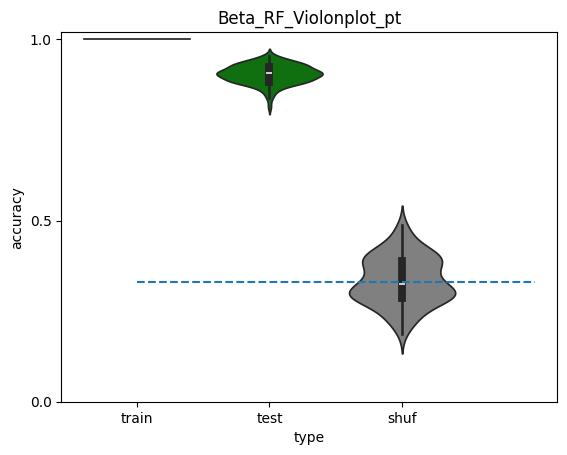   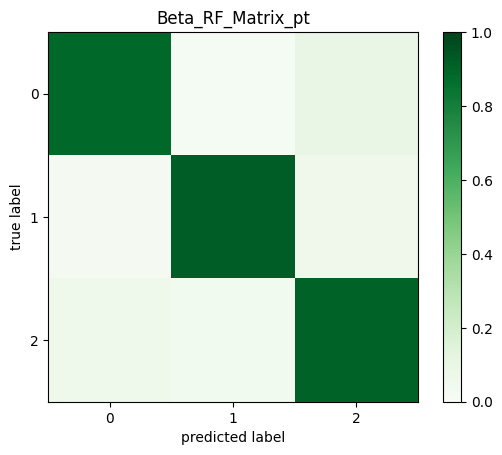

##### Gamma

In [ ]:
# gamma
X_vect_gamma_pt = psd_gamma_pt.get_data()[:,:,0] # Reshape features to be 2D
y_labs_gamma_pt = labels_pt

print("Gamma : ")
print("Features : ",X_vect_gamma_pt.shape)
print("Labels : ",y_labs_gamma_pt.shape)

# -----------------------
# Matrix for all frequences :
# -----------------------

n_sample = y_labs_gamma_pt.size
print('classes to predict:', np.unique(y_labs_gamma_pt))

plt.figure()
plt.imshow(y_labs_gamma_pt.reshape([n_sample,1]), aspect=0.03, interpolation='nearest', cmap='Set1')
plt.ylabel('sample index')
plt.xticks([])

plt.show()


# -----------------------
# Run function's classification  :
# -----------------------

#gamma
acc_gamma_3_pt, cm_gamma_3_pt = eval_classif_3(X_vect_gamma_pt, y_labs_gamma_pt) #MLR

# -----------------------
# gamma plot rf :
# -----------------------

# gamma_rf_Violonplot
sb.violinplot(data=acc_gamma_3_pt, x='type', y='score', hue='type', density_norm='width', palette=['brown','red','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('gamma_RF_Violonplot_pt')
plt.show()

# gamma rf Matrix
plt.figure()
plt.imshow(cm_gamma_3_pt.mean(0), cmap='Reds',vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('gamma_RF_Matrix_pt')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()

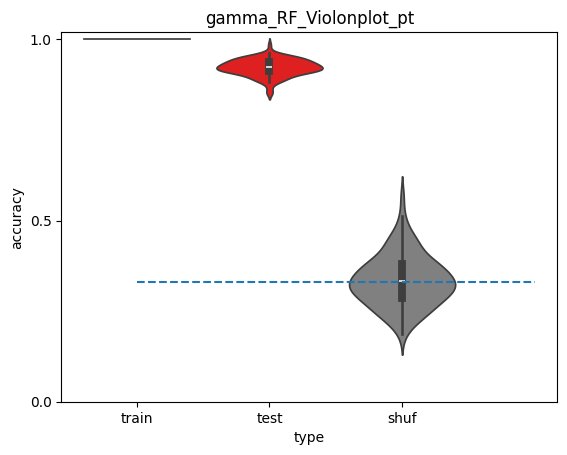 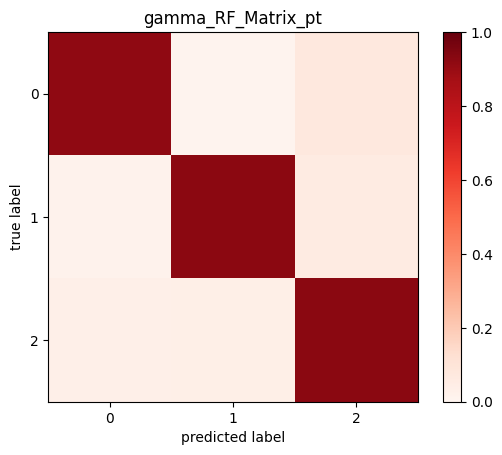

## Correlation on PSD

In [ ]:
def compute_hilbert_correlation_all_trials(psd_data):
    n_trials, n_channels, n_freqs = psd_data.shape
    correlation_matrices = np.zeros((n_trials, n_channels, n_channels))

    for trial in range(n_trials):
        for i in range(n_channels):
            for j in range(n_channels):
                # Calculate the signal envelope using the Hilbert transform
                envelope_i = np.abs(hilbert(psd_data[trial, i, :], axis=0))
                envelope_j = np.abs(hilbert(psd_data[trial, j, :], axis=0))

                # Calculate the correlation between the envelopes
                correlation = np.corrcoef(envelope_i, envelope_j)[0, 1]
                correlation_matrices[trial, i, j] = correlation

    return correlation_matrices

### MLR without RFE

In [ ]:
def eval_classif_4(X, y):

    # Define parameters to test for grid search
    param_grid = {
        'C': [0.01, 0.1, 1.0, 10.0, 100.0],
        'penalty': ['l2'],
        'solver': ['lbfgs'],
        'max_iter': [5000] # 100, 500, 1000, 5000, 10000, 15000
    }

    # Initialize the logistic regression model
    clf = LogisticRegression(n_jobs=-1)

    # Perform grid search to find the best parameters
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Initialize cross-validation
    cv_seed = int(time.time())
    n_splits = 100
    cvs = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=cv_seed)
    acc = pd.DataFrame()
    cm = np.zeros([n_splits, 3, 3])

    # List to store feature rankings for each split
    #rankings = []

    i_split = 0
    for train_ind, test_ind in tqdm(cvs.split(X, y)):
        # Train and test the classifier with the best parameters
        grid_search.fit(X[train_ind, :], y[train_ind])
        best_clf = grid_search.best_estimator_
        best_clf.fit(X[train_ind, :], y[train_ind])

        # Score on the training set
        d = {'type': ['train'], 'score': [best_clf.score(X[train_ind, :], y[train_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)

        # Score on the test set
        d = {'type': ['test'], 'score': [best_clf.score(X[test_ind, :], y[test_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)

        # Confusion matrix
        y_pred = best_clf.predict(X[test_ind, :])
        cm[i_split, :, :] = confusion_matrix(y[test_ind], y_pred, normalize='true')

        # best feature identification (post-hoc)
        #rfe = RFE(estimator=best_clf, n_features_to_select=5, step=5) # step of 5 features sufficient for 128 channels
        #rfe.fit(X[train_ind, :], y[train_ind])
        #ranking = rfe.ranking_
        #rankings.append(ranking)

        # Shuffle training indices
        train_ind_rand = np.random.permutation(train_ind)
        best_clf.fit(X[train_ind, :], y[train_ind_rand])

        # Score on the test set after shuffling
        d = {'type': ['shuf'], 'score': [best_clf.score(X[test_ind, :], y[test_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)

        i_split += 1

        return acc, cm 

#### STOP-IN and PUNCH-TROUG not here but the same code 

##### Alpah

In [ ]:
# Calculate the correlation for each frequency band
corr_all_trials_alpha_si = compute_hilbert_correlation_all_trials(psd_alpha_si.get_data())

def extract_features(correlation_matrix):
    # Extract values from the upper triangular matrix (excluding the diagonal)
    upper_triangle = correlation_matrix[np.triu_indices_from(correlation_matrix, k=1)]
    return upper_triangle

# Supposons que corr_all_trials_alpha_si soit votre matrice 3D de forme (642, 125, 125)
n_trials = corr_all_trials_alpha_si.shape[0]
features = []

for trial in range(n_trials):
    # Extraire les caractéristiques pour chaque essai
    upper_triangle = extract_features(corr_all_trials_alpha_si[trial, :, :])
    features.append(upper_triangle)

# Convertir la liste des caractéristiques en un tableau NumPy
features_all_alpha_si = np.array(features)

# Vérifiez la nouvelle forme
print(features_all_alpha_si.shape)

# alpha
X_vect_corr_alpha_si = features_all_alpha_si 
y_labs_alpha_si = labels_si

print("Alpha : ")
print("Features : ",X_vect_corr_alpha_si.shape)
print("Labels : ",y_labs_alpha_si.shape)

# -----------------------
# Run function's classification  :
# -----------------------

#alpha
acc_corr_alpha_1_si, cm_corr_alpha_2_si = eval_classif_4(X_vect_corr_alpha_si, y_labs_alpha_si) #MLR

# -----------------------
# Alpha plot MLR  :
# -----------------------

# Alpha_MLR_Violonplot
sb.violinplot(data=acc_corr_alpha_1_si, x='type', y='score', hue='type', density_norm='width', palette=['brown','blue','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('Alpha_MLR_Violonplot_si')
plt.show()

# Alpha MLR Matrix
plt.figure()
plt.imshow(cm_corr_alpha_2_si.mean(0), cmap='Blues',vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('Alpha_MLR_Matrix_si')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()

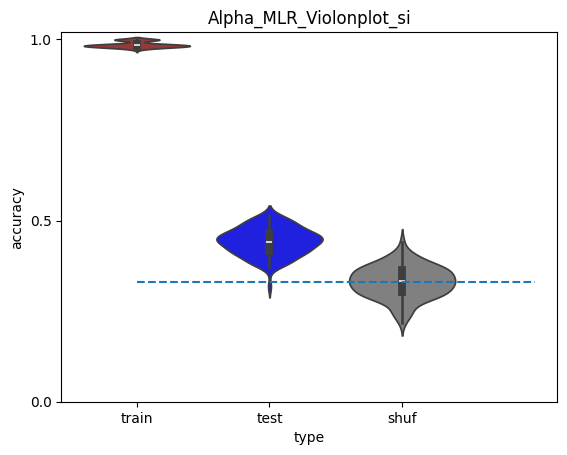 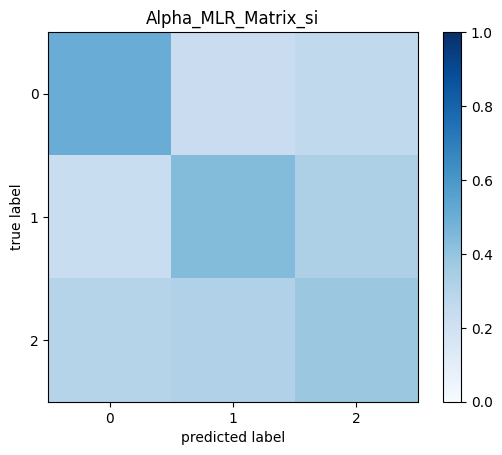   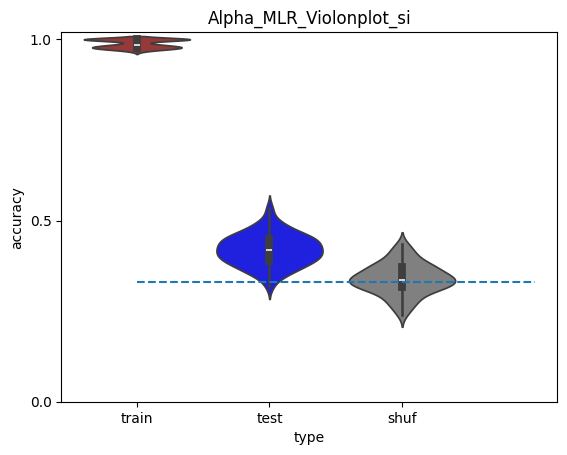  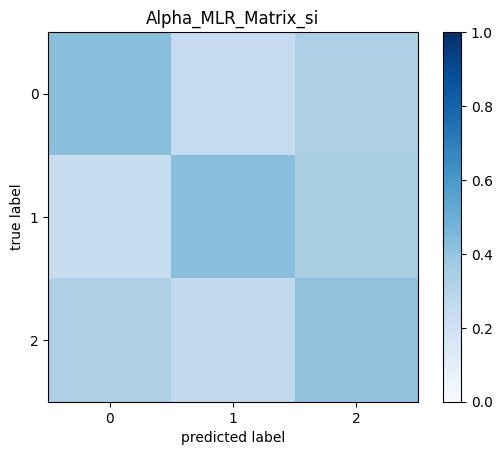 

##### Beta


In [ ]:
# Calculate the correlation for each frequency band
corr_all_trials_beta_si = compute_hilbert_correlation_all_trials(psd_beta_si.get_data())

def extract_features(correlation_matrix):
    # Extract values from the upper triangular matrix (excluding the diagonal)
    upper_triangle = correlation_matrix[np.triu_indices_from(correlation_matrix, k=1)]
    return upper_triangle

# Supposons que corr_all_trials_alpha_si soit votre matrice 3D de forme (642, 125, 125)
n_trials = corr_all_trials_beta_si.shape[0]
features = []

for trial in range(n_trials):
    # Extraire les caractéristiques pour chaque essai
    upper_triangle = extract_features(corr_all_trials_beta_si[trial, :, :])
    features.append(upper_triangle)

# Convertir la liste des caractéristiques en un tableau NumPy
features_all_beta_si = np.array(features)

# Vérifiez la nouvelle forme
print(features_all_beta_si.shape)

# beta
X_vect_corr_beta_si = features_all_beta_si 
y_labs_beta_si = labels_si

print("Beta : ")
print("Features : ",X_vect_corr_beta_si.shape)
print("Labels : ",y_labs_beta_si.shape)

# -----------------------
# Run function's classification  :
# -----------------------

#beta
acc_corr_beta_1_si, cm_corr_beta_2_si = eval_classif_4(X_vect_corr_beta_si, y_labs_beta_si) #MLR

# -----------------------
# beta plot MLR  :
# -----------------------

# beta_MLR_Violonplot
sb.violinplot(data=acc_corr_beta_1_si, x='type', y='score', hue='type', density_norm='width', palette=['brown','green','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('beta_MLR_Violonplot_si')
plt.show()

# beta MLR Matrix
plt.figure()
plt.imshow(cm_corr_beta_2_si.mean(0), cmap='Greens',vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('beta_MLR_Matrix_si')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()

 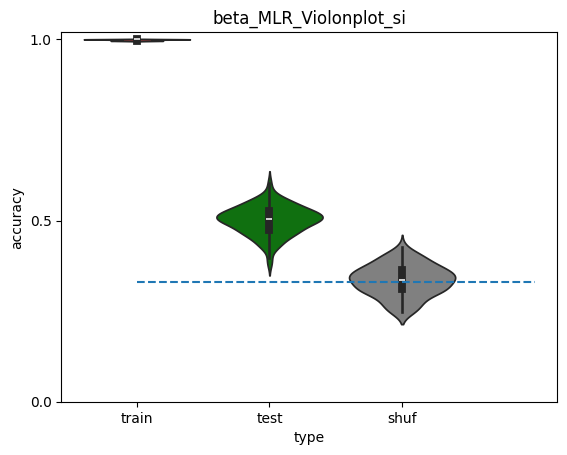 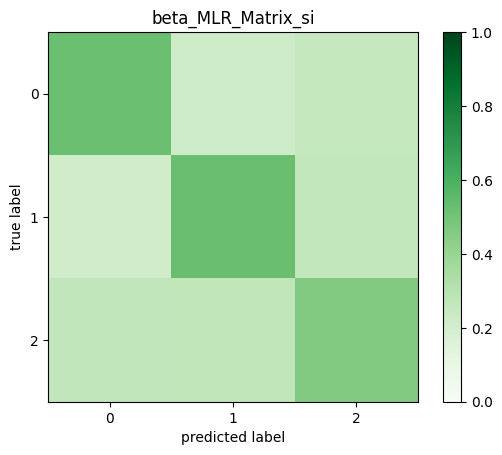 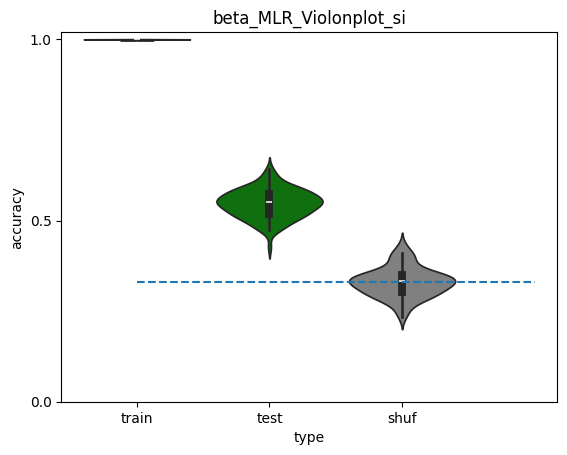 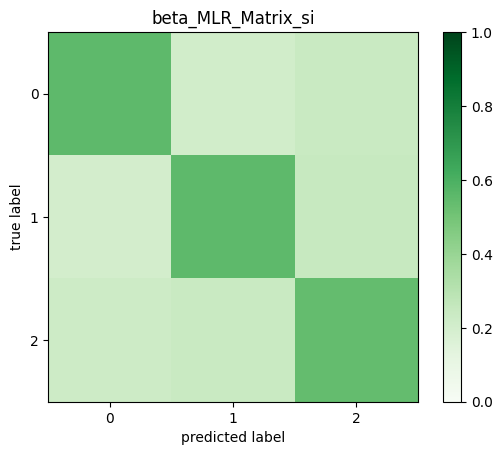 

##### Gamma

In [ ]:
# Calculate the correlation for each frequency band
corr_all_trials_gamma_si = compute_hilbert_correlation_all_trials(psd_gamma_si.get_data())

def extract_features(correlation_matrix):
    # Extract values from the upper triangular matrix (excluding the diagonal)
    upper_triangle = correlation_matrix[np.triu_indices_from(correlation_matrix, k=1)]
    return upper_triangle

# Supposons que corr_all_trials_alpha_si soit votre matrice 3D de forme (642, 125, 125)
n_trials = corr_all_trials_gamma_si.shape[0]
features = []

for trial in range(n_trials):
    # Extraire les caractéristiques pour chaque essai
    upper_triangle = extract_features(corr_all_trials_gamma_si[trial, :, :])
    features.append(upper_triangle)

# Convertir la liste des caractéristiques en un tableau NumPy
features_all_gamma_si = np.array(features)

# Vérifiez la nouvelle forme
print(features_all_gamma_si.shape)

# gamma
X_vect_corr_gamma_si = features_all_gamma_si 
y_labs_gamma_si = labels_si

print("gamma : ")
print("Features : ",X_vect_corr_gamma_si.shape)
print("Labels : ",y_labs_gamma_si.shape)

# -----------------------
# Run function's classification  :
# -----------------------

#gamma
acc_corr_gamma_1_si, cm_corr_gamma_2_si = eval_classif_4(X_vect_corr_gamma_si, y_labs_gamma_si) #MLR

# -----------------------
# gamma plot MLR  :
# -----------------------

# gamma_MLR_Violonplot
sb.violinplot(data=acc_corr_gamma_1_si, x='type', y='score', hue='type', density_norm='width', palette=['brown','red','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('gamma_MLR_Violonplot_si')
plt.show()

# gamma MLR Matrix
plt.figure()
plt.imshow(cm_corr_gamma_2_si.mean(0), cmap='Reds',vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('gamma_MLR_Matrix_si')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()

 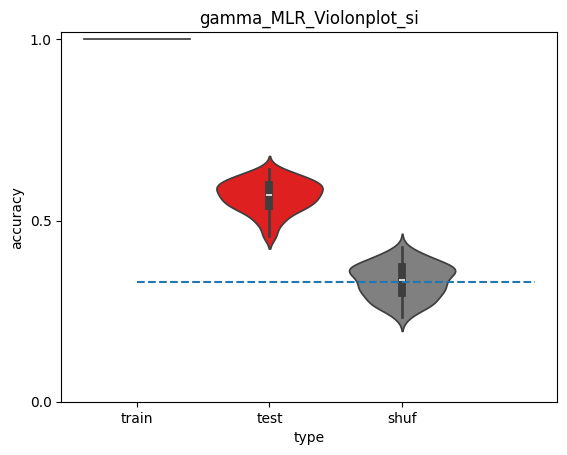 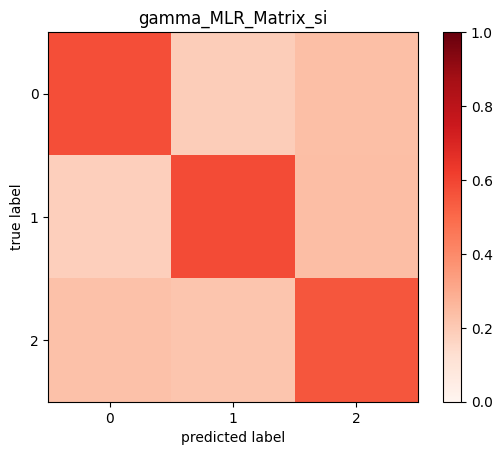 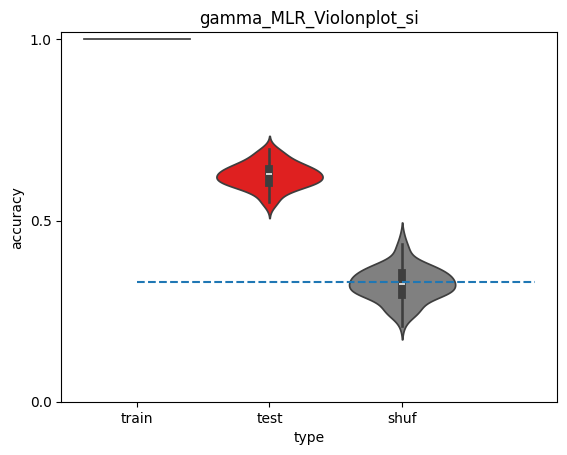 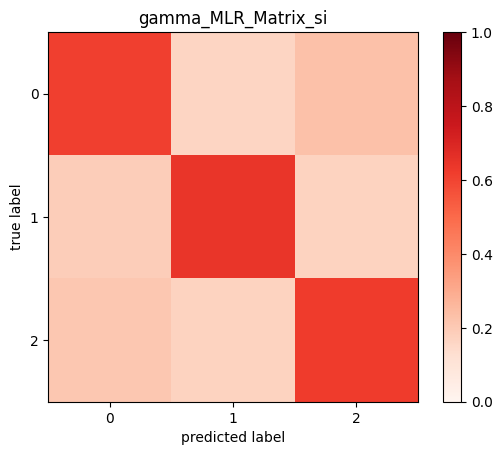 

### 1NN

#### STOP-IN and PUNCH-TROUG not here but the same code 

##### Alpha

In [ ]:
# alpha
X_vect_corr_alpha_si = features_all_alpha_si 
y_labs_alpha_si = labels_si

print("Alpha : ")
print("Features : ",X_vect_corr_alpha_si.shape)
print("Labels : ",y_labs_alpha_si.shape)

# -----------------------
# Run function's classification  :
# -----------------------

#alpha
acc_corr_alpha_2_si, cm_corr_alpha_2_si = eval_classif_2(X_vect_corr_alpha_si, y_labs_alpha_si) #MLR

# -----------------------
# Alpha plot kNN  :
# -----------------------

# Alpha_knn_Violonplot
sb.violinplot(data=acc_corr_alpha_2_si, x='type', y='score', hue='type', density_norm='width', palette=['brown','blue','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('Alpha_kNN_Violonplot_si')
plt.show()

# Alpha kNN Matrix
plt.figure()
plt.imshow(cm_corr_alpha_2_si.mean(0), cmap='Blues',vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('Alpha_kNN_Matrix_si')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()

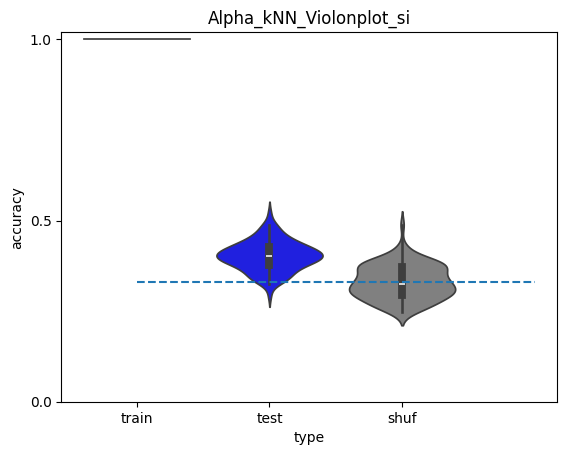 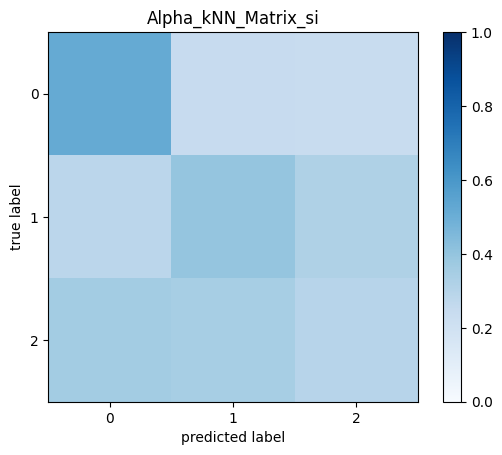 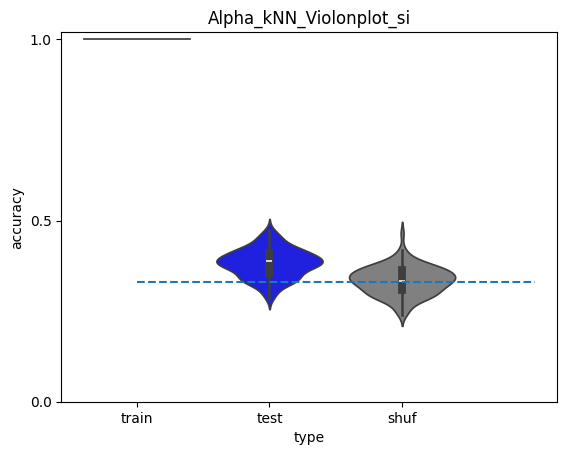 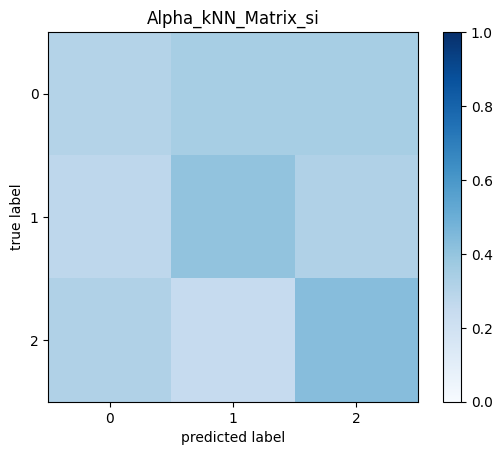

##### Beta

In [ ]:
# beta
X_vect_corr_beta_si = features_all_beta_si 
y_labs_beta_si = labels_si

print("Beta : ")
print("Features : ",X_vect_corr_beta_si.shape)
print("Labels : ",y_labs_beta_si.shape)

# -----------------------
# Run function's classification  :
# -----------------------

#beta
acc_corr_beta_2_si, cm_corr_beta_2_si = eval_classif_2(X_vect_corr_beta_si, y_labs_beta_si) #1NN

# -----------------------
# beta plot kNN  :
# -----------------------

# beta_knn_Violonplot
sb.violinplot(data=acc_corr_beta_2_si, x='type', y='score', hue='type', density_norm='width', palette=['brown','green','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('beta_kNN_Violonplot_si')
plt.show()

# beta kNN Matrix
plt.figure()
plt.imshow(cm_corr_beta_2_si.mean(0), cmap='Greens',vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('beta_kNN_Matrix_si')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()

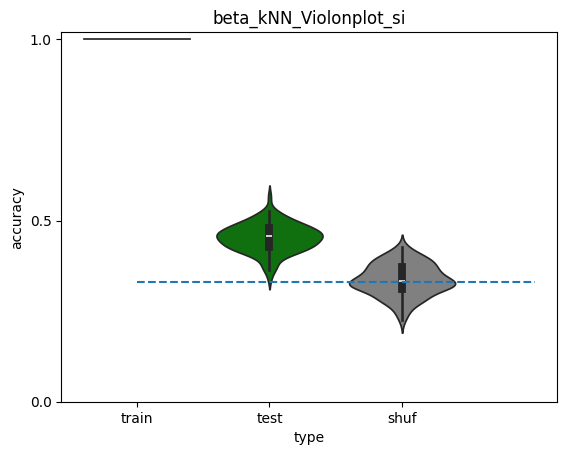 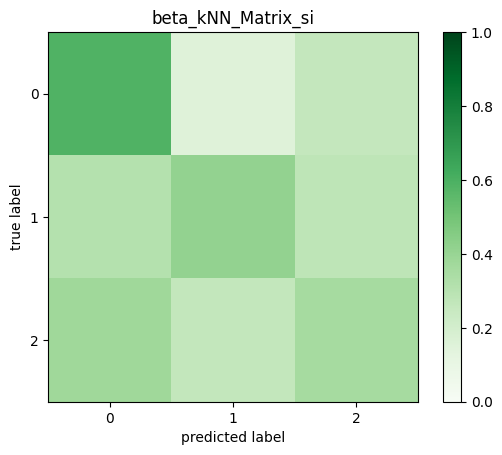 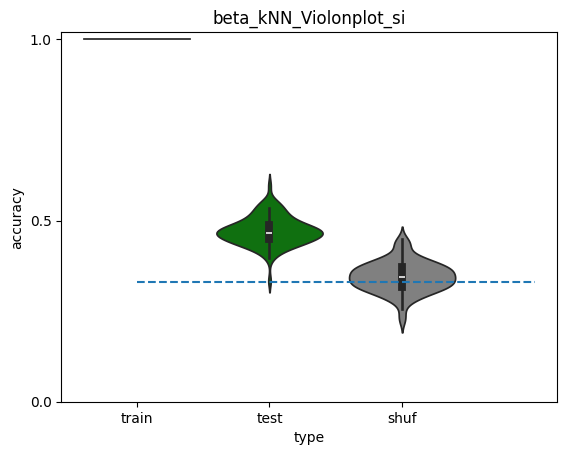 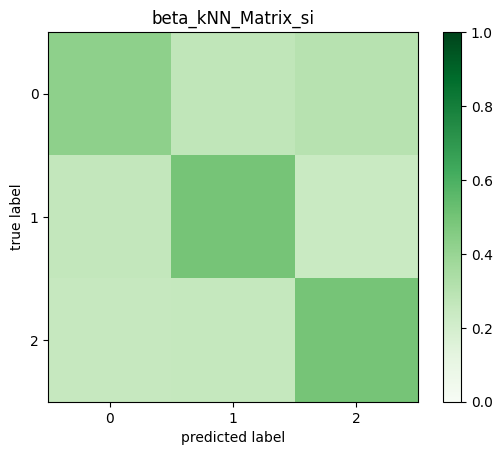

##### Gamma

In [ ]:
# gamma
X_vect_corr_gamma_si = features_all_gamma_si 
y_labs_gamma_si = labels_si

print("gamma : ")
print("Features : ",X_vect_corr_gamma_si.shape)
print("Labels : ",y_labs_gamma_si.shape)

# -----------------------
# Run function's classification  :
# -----------------------

#gamma
acc_corr_gamma_2_si, cm_corr_gamma_2_si = eval_classif_2(X_vect_corr_gamma_si, y_labs_gamma_si) #1NN

# -----------------------
# gamma plot kNN  :
# -----------------------

# gamma_knn_Violonplot
sb.violinplot(data=acc_corr_gamma_2_si, x='type', y='score', hue='type', density_norm='width', palette=['brown','red','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('gamma_kNN_Violonplot_si')
plt.show()

# gamma kNN Matrix
plt.figure()
plt.imshow(cm_corr_gamma_2_si.mean(0), cmap='Reds',vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('gamma_kNN_Matrix_si')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()

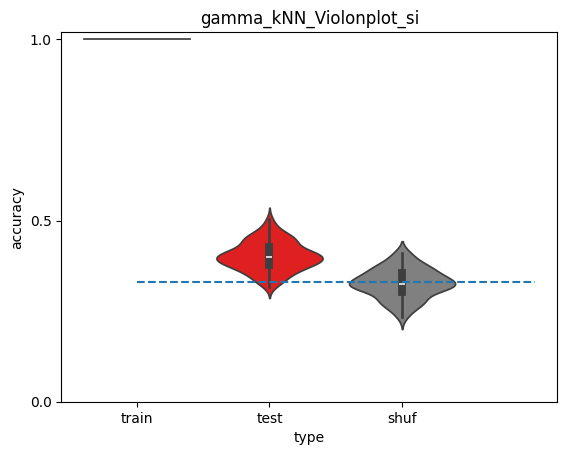 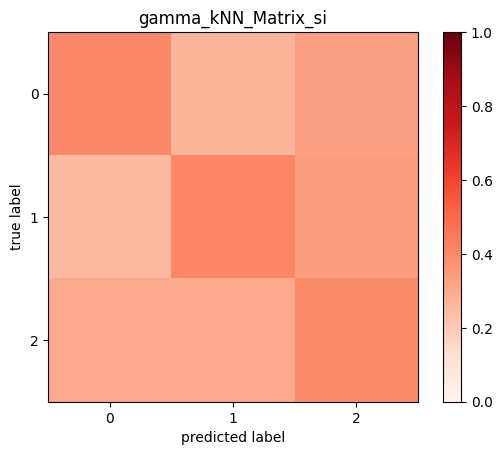 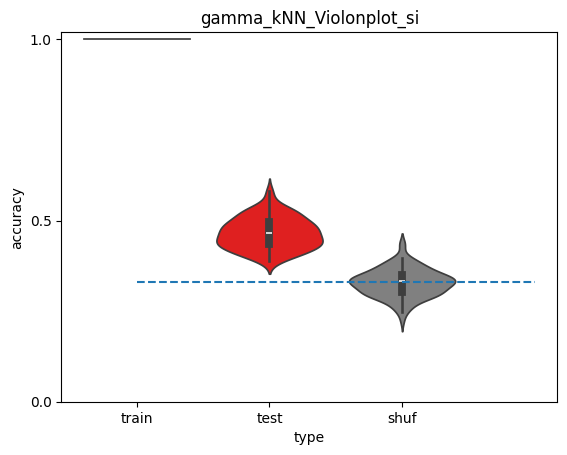 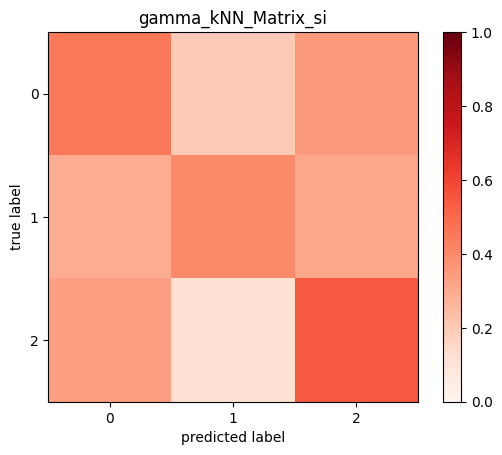

### Random Forest

#### STOP-IN and PUNCH-TROUGH not here but same code

##### Alpha

In [ ]:
# alpha
X_vect_corr_alpha_si = features_all_alpha_si 
y_labs_alpha_si = labels_si

print("Alpha : ")
print("Features : ",X_vect_corr_alpha_si.shape)
print("Labels : ",y_labs_alpha_si.shape)

# -----------------------
# Run function's classification  :
# -----------------------

#alpha
acc_corr_alpha_3_si, cm_corr_alpha_2_si = eval_classif_3(X_vect_corr_alpha_si, y_labs_alpha_si) #rf

# -----------------------
# Alpha plot rf  :
# -----------------------

# Alpha_rf_Violonplot
sb.violinplot(data=acc_corr_alpha_3_si, x='type', y='score', hue='type', density_norm='width', palette=['brown','blue','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('Alpha_rf_Violonplot_si')
plt.show()

# Alpha kNN Matrix
plt.figure()
plt.imshow(cm_corr_alpha_2_si.mean(0), cmap='Blues',vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('Alpha_rf_Matrix_si')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()

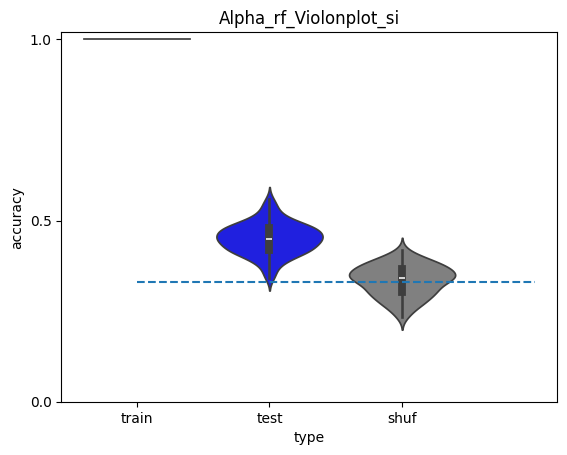 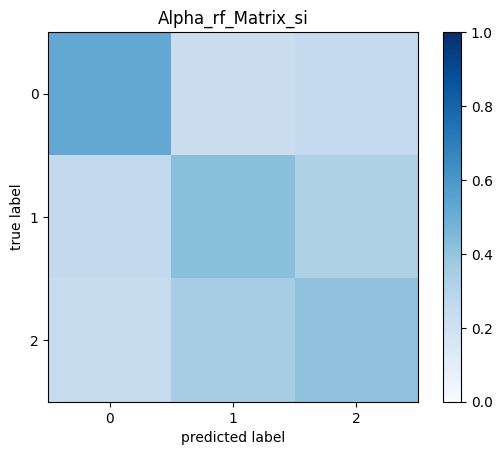 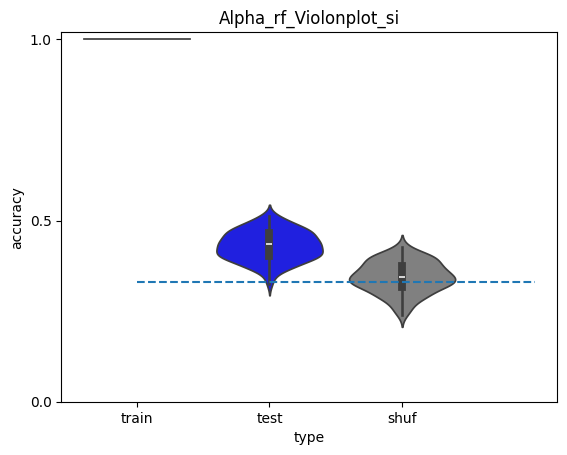 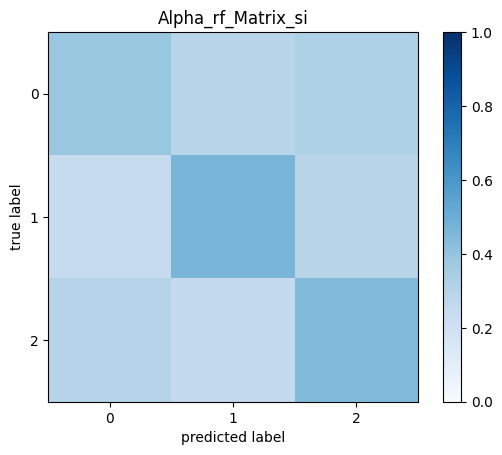 

##### Beta

In [ ]:
# beta
X_vect_corr_beta_si = features_all_beta_si 
y_labs_beta_si = labels_si

print("Beta : ")
print("Features : ",X_vect_corr_beta_si.shape)
print("Labels : ",y_labs_beta_si.shape)

# -----------------------
# Run function's classification  :
# -----------------------

#beta
acc_corr_beta_3_si, cm_corr_beta_2_si = eval_classif_3(X_vect_corr_beta_si, y_labs_beta_si) #rf

# -----------------------
# beta plot rf  :
# -----------------------

# beta_rf_Violonplot
sb.violinplot(data=acc_corr_beta_3_si, x='type', y='score', hue='type', density_norm='width', palette=['brown','green','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('beta_rf_Violonplot_si')
plt.show()

# beta rf Matrix
plt.figure()
plt.imshow(cm_corr_beta_2_si.mean(0), cmap='Greens',vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('beta_rf_Matrix_si')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()

 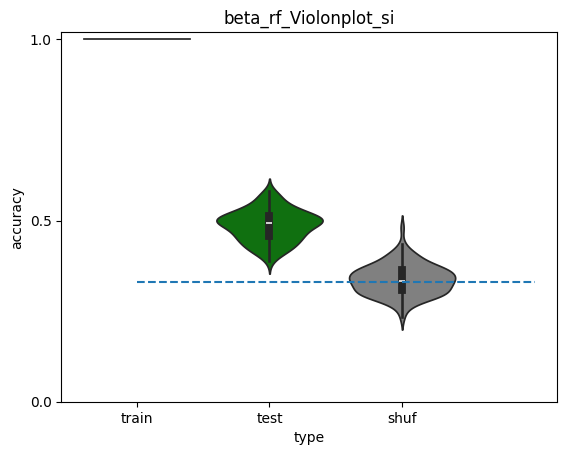 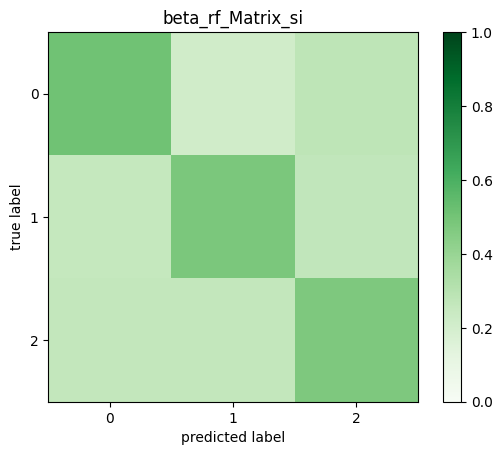 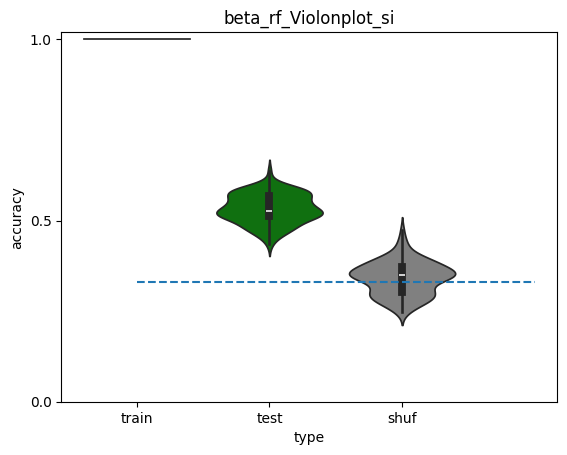 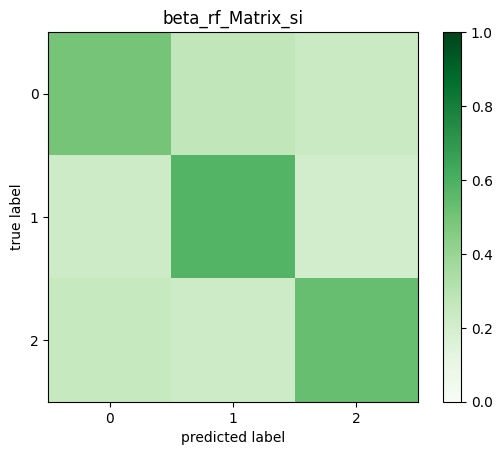

##### Gamma

In [ ]:
# gamma
X_vect_corr_gamma_si = features_all_gamma_si 
y_labs_gamma_si = labels_si

print("gamma : ")
print("Features : ",X_vect_corr_gamma_si.shape)
print("Labels : ",y_labs_gamma_si.shape)

# -----------------------
# Run function's classification  :
# -----------------------

#gamma
acc_corr_gamma_3_si, cm_corr_gamma_2_si = eval_classif_3(X_vect_corr_gamma_si, y_labs_gamma_si) #rf

# -----------------------
# gamma plot rf  :
# -----------------------

# gamma_rf_Violonplot
sb.violinplot(data=acc_corr_gamma_3_si, x='type', y='score', hue='type', density_norm='width', palette=['brown','red','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('gamma_rf_Violonplot_si')
plt.show()

# Alpha kNN Matrix
plt.figure()
plt.imshow(cm_corr_gamma_2_si.mean(0), cmap='Reds')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('gamma_rf_Matrix_si')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()

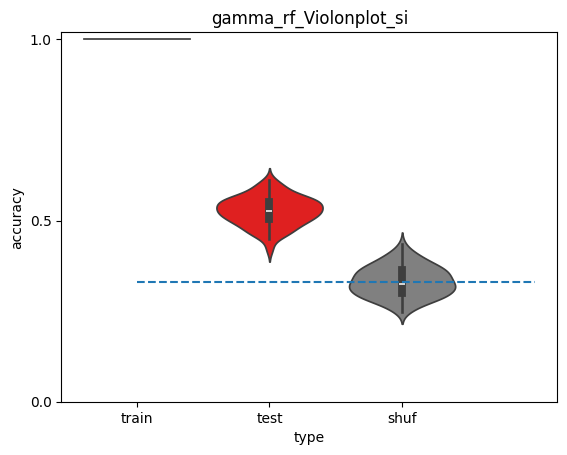 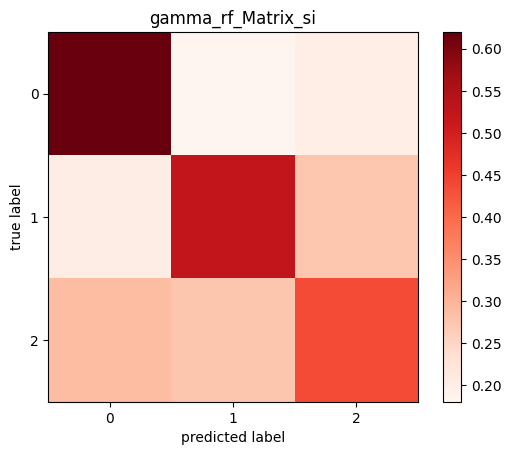 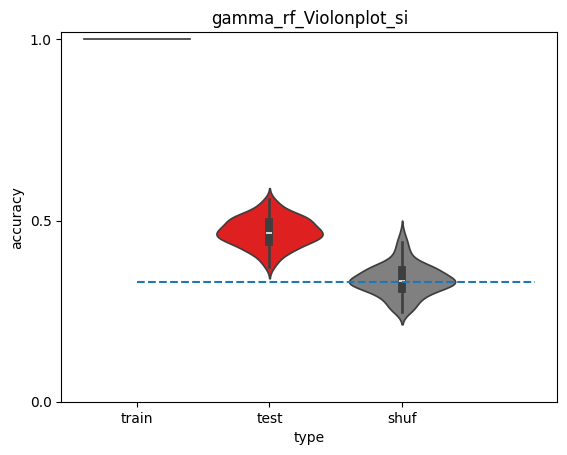 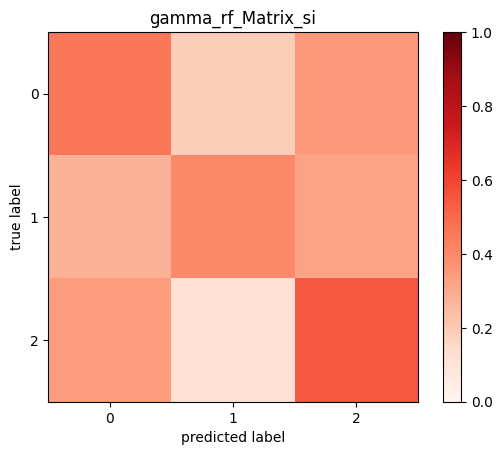